In [54]:
import numpy as np
import pandas as pd
from pyDOE3 import fullfact
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import minmax_scale
from scipy import stats 

# Parte 1: Diseño Factorial

## ¿Por qué es necesario realizar un diseño experimental?
1. Un diseño experimental nos permite generar un **plan** de nuestro experimento. Lo que nos permite probar las diferentes combinaciones de nuestros datos de forma sistemática.
2. En ciertos casos, por ejemplo un diseño factorial, diseños experimentales permiten entender mejor el sistema (interacciones).
3. Los diseños experimentales, si son bien realizados, permiten disminuir la cantidad de experimentos a realizar.
4. En casos particulares, los diseños experimentales permiten predecir futuros experimentos que permitan entender mejor el comportamiento del sistema.
    - Ver: [Bayesian Experimental Design](https://arxiv.org/pdf/2302.14545) y aplicaciones como [Diseño de comunidades Bacterianas](https://www.biorxiv.org/content/10.1101/2025.03.03.641341v1.full.pdf+html)

Así, un diseño experimental provee de herramientas para realizar mejores experimentos y planificarnos en nuestro día a día en el laboratorio.

Por otra parte, el área del diseño experimental no solo provee de métodos de formulación de un *setting* experimental, sino de herramientas que permitan analizarlos de mejor manera -las cuales iremos discutinedo a lo largo de al unidad.

### Diseño Factorial Completo

El diseño factorial completo, como su nombre menciona, genera todas las combinaciones entre las variables (como el factorial $!$). Esto nos permite evaluar como se interactuan todos los niveles de las variables que poseemos a nuestra disposición. 

Así, por ejemplo, teniendo un 3 factores  $A, B, C$ y 2, 3, 4, niveles por factor. Se deben realizar $2 * 3 * 4 * n$ cantidad de experimentos, considerando $n$ la cantidad de repeticiones. **¿Por qué son importantes las repeticiones?**

In [87]:
# Implementacion en python
levels = [2,3,4] # niveles por factor
design = fullfact(levels) # matriz de diseño
rep = 3
X = np.repeat(design, rep, axis=0)
df = pd.DataFrame(X, columns=['A1', 'B1', 'C1']).astype('int').astype('category') # definimos como categorias
display(design)
display(df)

array([[0., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 1., 0.],
       [0., 2., 0.],
       [1., 2., 0.],
       [0., 0., 1.],
       [1., 0., 1.],
       [0., 1., 1.],
       [1., 1., 1.],
       [0., 2., 1.],
       [1., 2., 1.],
       [0., 0., 2.],
       [1., 0., 2.],
       [0., 1., 2.],
       [1., 1., 2.],
       [0., 2., 2.],
       [1., 2., 2.],
       [0., 0., 3.],
       [1., 0., 3.],
       [0., 1., 3.],
       [1., 1., 3.],
       [0., 2., 3.],
       [1., 2., 3.]])

,A1,B1,C1
0,0,0,0
1,0,0,0
2,0,0,0
3,1,0,0
4,1,0,0
...,...,...,...
67,0,2,3
68,0,2,3
69,1,2,3
70,1,2,3


In [88]:
### simulamos nuestros datos
### Comentario 
datos_min_max = df.copy()
datos_min_max = datos_min_max.apply(lambda x: minmax_scale(x, feature_range=(-1, 1)))

w = {
    'w1': 0.5, 'w2': 4, 'w3': 3,
    'w12': 1, 'w13': 0.01, 'w23': 1.2,
    'w123': 6
}
# la barra \ es para continuar la linea


y = 1.5 * datos_min_max['A1'] * w['w1'] + datos_min_max['B1'] * w['w2'] + datos_min_max['C1'] * w['w3'] + \
    datos_min_max['A1'] * datos_min_max['B1'] * w['w12'] + \
    datos_min_max['A1'] * datos_min_max['C1'] * w['w13'] + \
    datos_min_max['B1'] * datos_min_max['C1'] * w['w23'] + \
    datos_min_max['A1'] * datos_min_max['B1'] * datos_min_max['C1'] * w['w123'] + \
    np.random.normal(0, 0.1, len(datos_min_max)) # error aleatorio
    
df['y'] = y
display(df)

,A1,B1,C1,y
0,0,0,0,-11.562374
1,0,0,0,-11.425271
2,0,0,0,-11.487296
3,1,0,0,-0.276203
4,1,0,0,0.103173
...,...,...,...,...
67,0,2,3,0.533774
68,0,2,3,0.456174
69,1,2,3,16.072637
70,1,2,3,15.945729


## Visualización de experimentos
> Genere las curvas de respuesta entre las variables $x_1$, $x_2$ y la respuesta $y$. Para ello, mantenga $x_3 = 0$. ¿Es posible visualizar interacción entre $x_1$ y $x_2$? ¿Ocurre lo mismo entre $x_1$ y $x_3$?

En este caso poseemos dos opciones, y presentaremos las dos 😎.


### Caso continuo

En el caso de que las variables explicativas sean continuas, es posible realizar una superficie de respuesta basada en una regresión lineal -u otro tipo de modelo- para estimar el efecto e interacción de las variables sobre la variable de de respuesta. Debido a limitaciones de software y visualización, se realizan gráficas en 3D donde los ejes X e Y corresponden a las variables explicativas, mientras que el eje Z la de respuesta.

Usando los mismos pesos anteriores

In [89]:
###
import plotly.express as px
import plotly.graph_objects as go
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D  

xi = np.linspace(-1, 1, 100)
yi = np.linspace(-1, 1, 100)
zi = 0

xi, yi = np.meshgrid(xi, yi)
response = 1.5 * xi * w['w1'] + yi * w['w2'] + zi * w['w3'] + \
    xi * yi * w['w12'] + \
    xi * zi * w['w13'] + \
    yi * zi * w['w23'] + \
    xi * yi * zi * w['w123'] 

fig = go.Figure(go.Surface(x = xi, y = yi, z = response))
fig.update_layout(scene = dict(xaxis_title='X', yaxis_title='Y', zaxis_title='response'),
                      autosize=False, width=500, height=500,
                   margin=dict(
                            l=50,
                            r=50,
                            b=100,
                            t=100,
                            pad=4)
    )
fig.show()


In [90]:
xi = np.linspace(-1, 1, 100)
yi = 0
zi = np.linspace(-1, 1, 100)

xi, zi = np.meshgrid(xi, zi)
response = 1.5 * xi * w['w1'] + yi * w['w2'] + zi * w['w3'] + \
    xi * yi * w['w12'] + \
    xi * zi * w['w13'] + \
    yi * zi * w['w23'] + \
    xi * yi * z * w['w123'] 

fig = go.Figure(go.Surface(x = xi, y = zi, z = response))
fig.update_layout(scene = dict(xaxis_title='X', yaxis_title='Z', zaxis_title='response'),
                      autosize=False, width=500, height=500,
                   margin=dict(
                            l=50,
                            r=50,
                            b=100,
                            t=100,
                            pad=4)
    )
fig.show()


A simple vista no es posible encontrar interacciones fuertes entre las variables $x_1$ y $x_2$, y $x_1$ y $x_3$

### Caso discreto

En el caso discreto o categórico, es más sencillo encontrar interacciones debido a que es posible graficar el efecto de las variables al evaluar las combinaciones de los datos. Para esto, realizamos un gráfico de dispersión que combine los datos que queremos evaluar. Para esto utilizamos los datos discretos que generamos previamente.

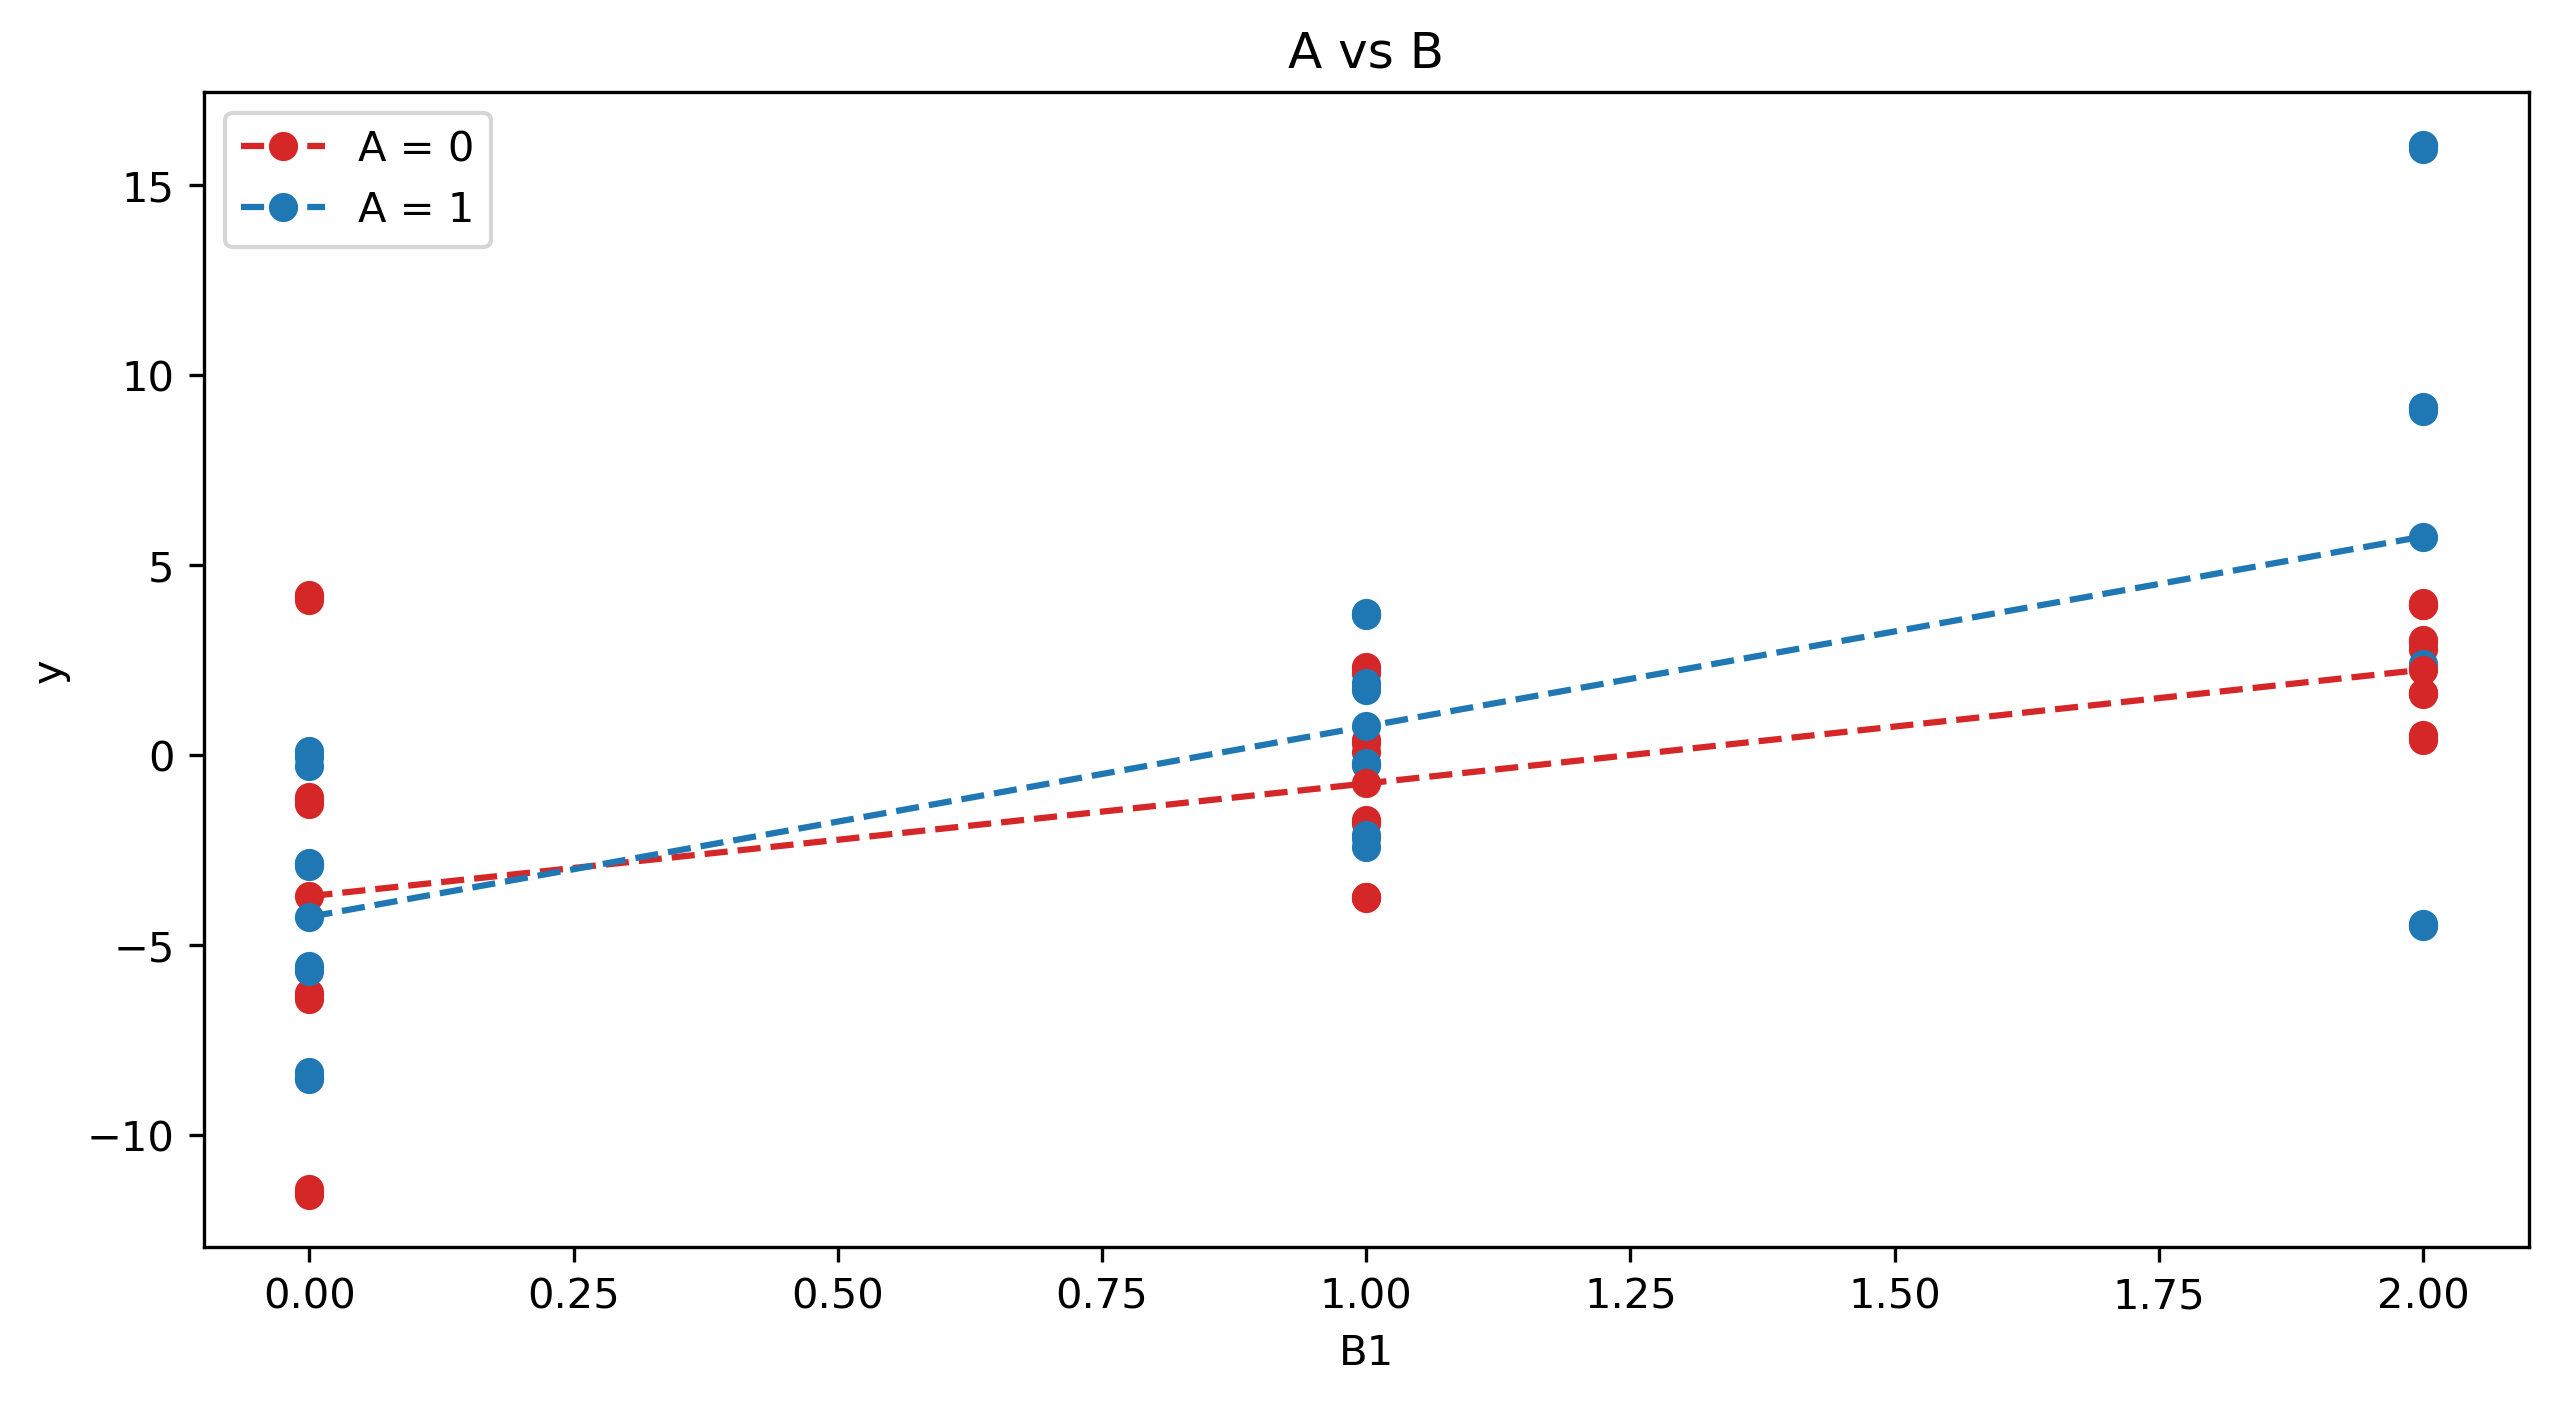

In [91]:
# df contiene los datos categóricos

# A con B
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
a_color = {0 : 'tab:red', 1 : 'tab:blue'}

a_means = {0:[], 1:[]}
for a in df['A1'].unique():
    caso_A = df[df['A1'] == a]
    for b in df['B1'].unique():
        caso_AB = df[(df['A1'] == a) & (df['B1'] == b)]
        ax.scatter(caso_AB['B1'], caso_AB['y'], color = a_color[a])
        a_means[a].append(caso_AB['y'].mean())
        
for k in a_means.keys():
    ax.plot(df['B1'].unique(), a_means[k], color = a_color[k], marker='o', linestyle='--',
            label = f'A = {k}')

ax.set_xlabel('B1')
ax.set_ylabel('y')
ax.set_title('A vs B')
ax.legend()

Y podemos realizar el mismo procedimiento para la interacción entre otras variables.

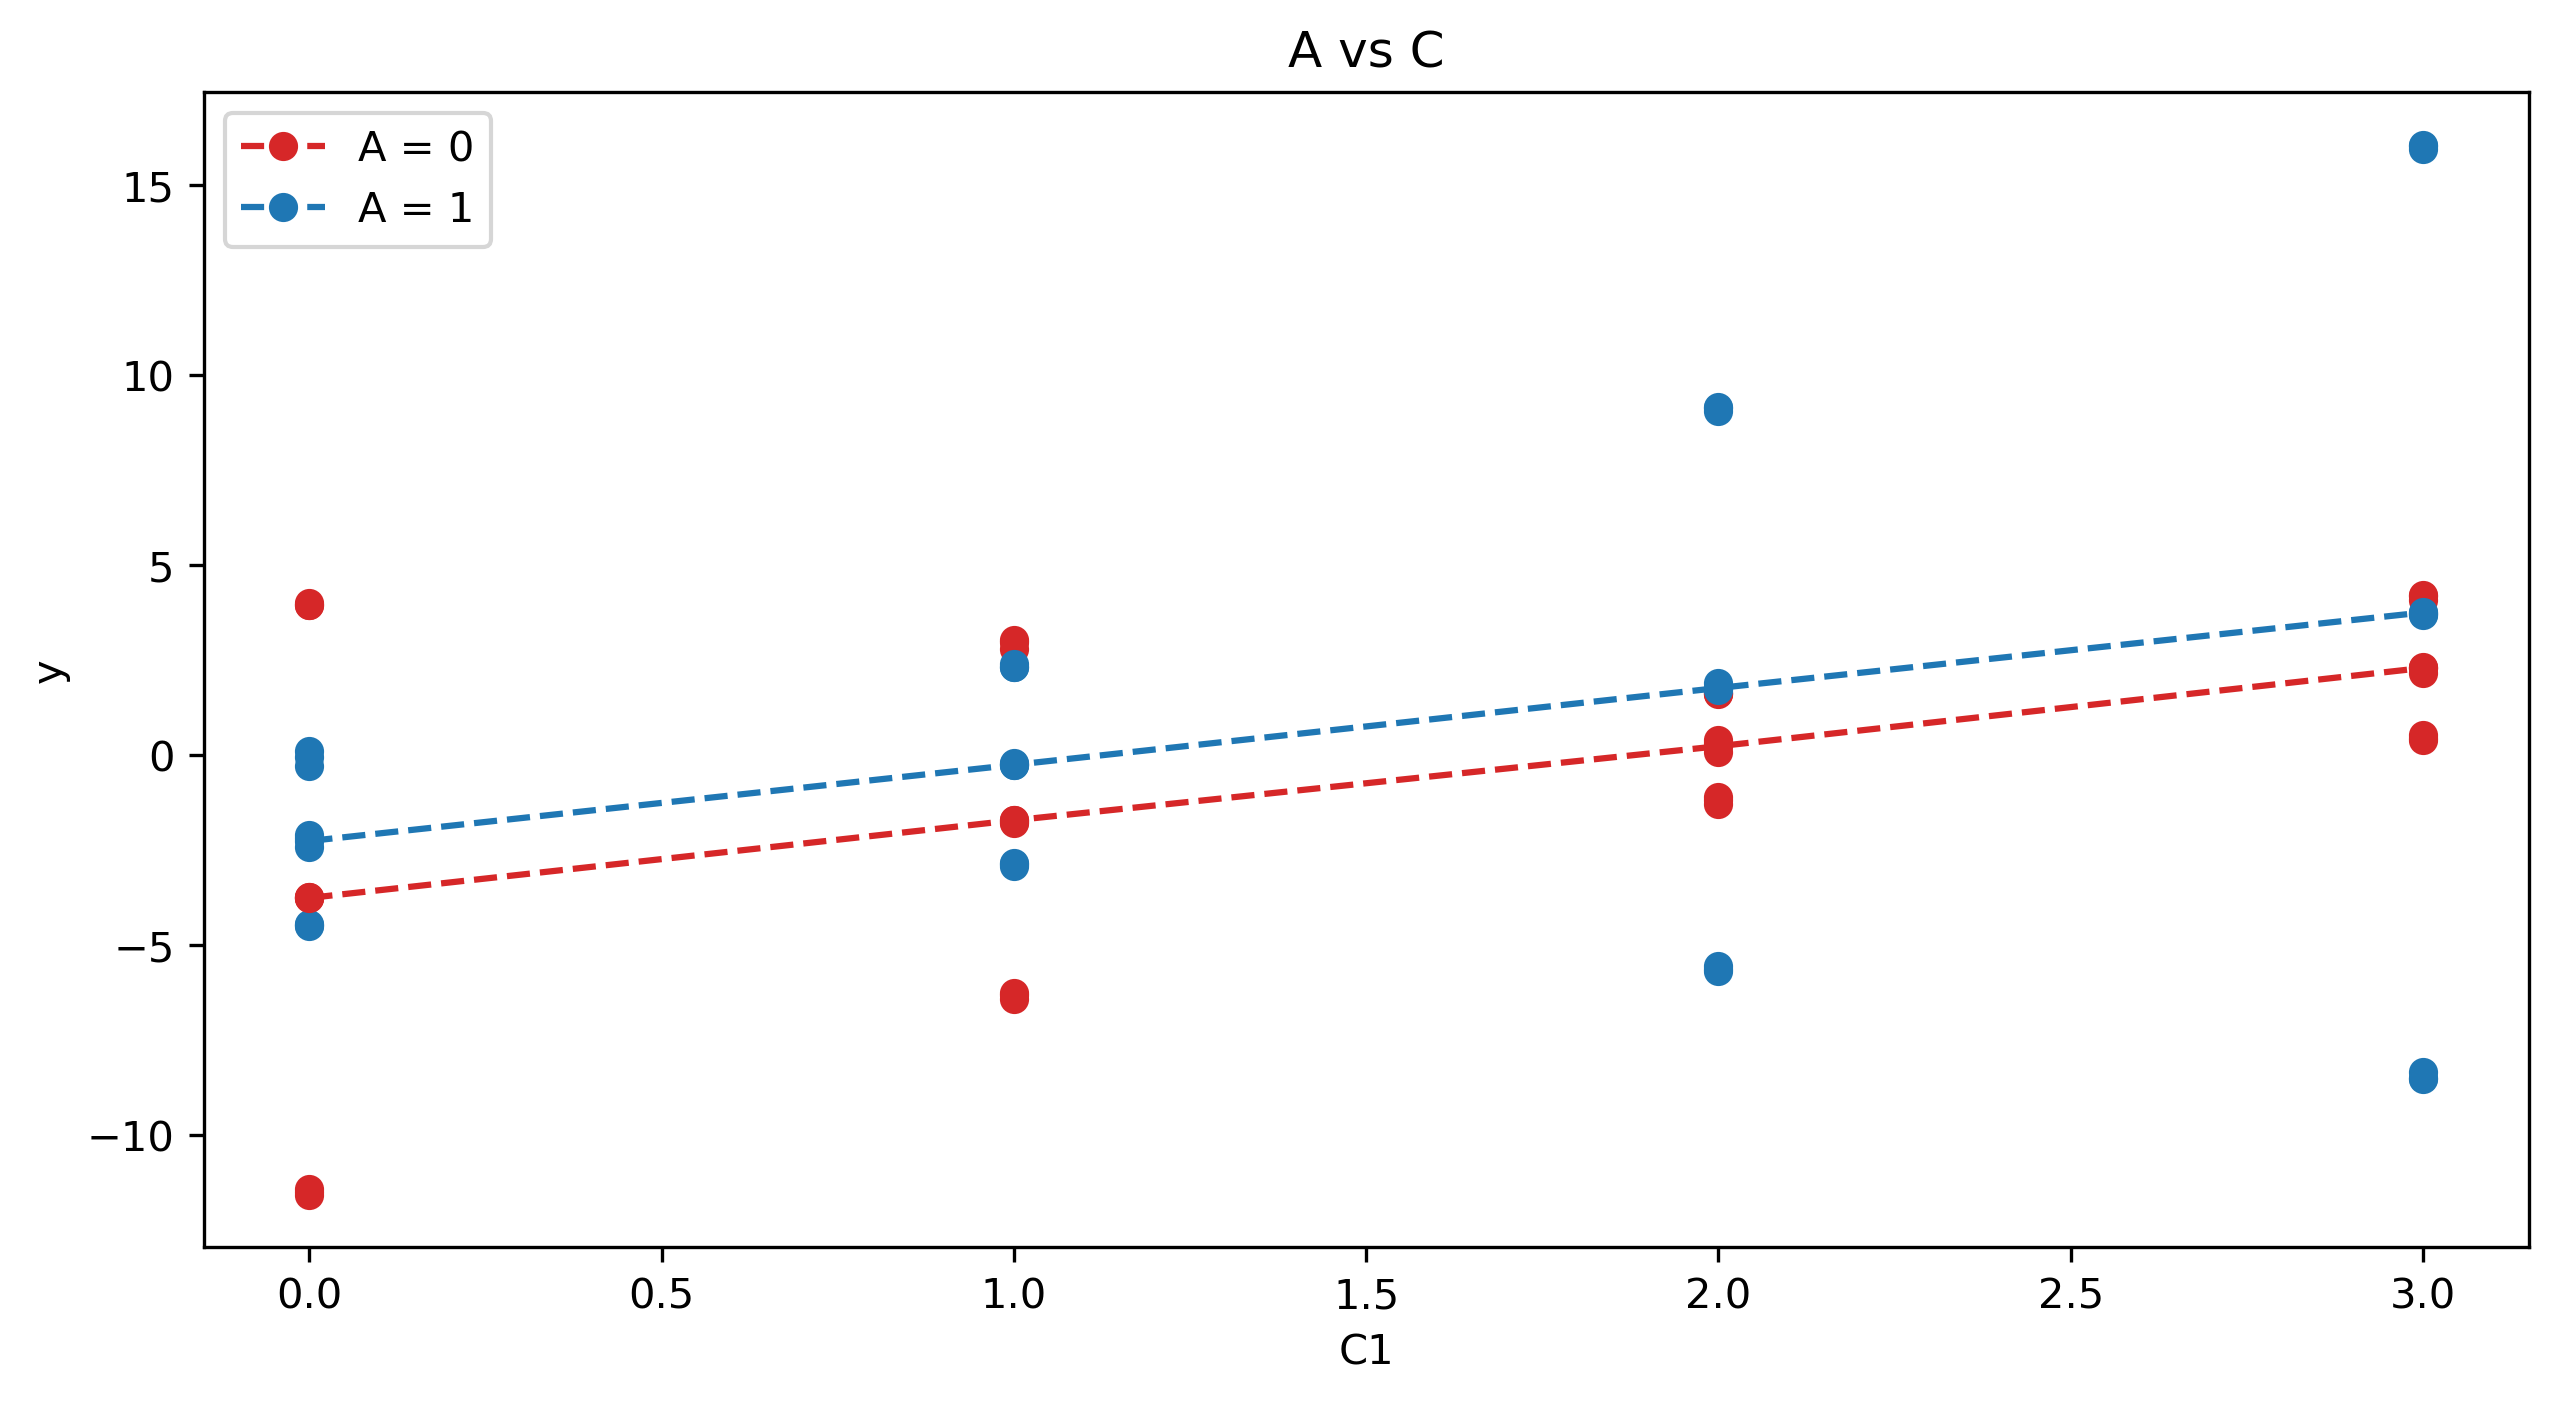

In [92]:
# df contiene los datos categóricos

# A con B
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
a_color = {0 : 'tab:red', 1 : 'tab:blue'}

a_means = {0:[], 1:[]}
for a in df['A1'].unique():
    caso_A = df[df['A1'] == a]
    for c in df['C1'].unique():
        caso_AC = df[(df['A1'] == a) & (df['C1'] == c)]
        ax.scatter(caso_AC['C1'], caso_AC['y'], color = a_color[a])
        a_means[a].append(caso_AC['y'].mean())
        
for k in a_means.keys():
    ax.plot(df['C1'].unique(), a_means[k], color = a_color[k], marker='o', linestyle='--',
            label = f'A = {k}')

ax.set_xlabel('C1')
ax.set_ylabel('y')
ax.set_title('A vs C')
ax.legend()

Aunque, para facilidad de el gráfico es posible utilizar una función ya implementada en python.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:131: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



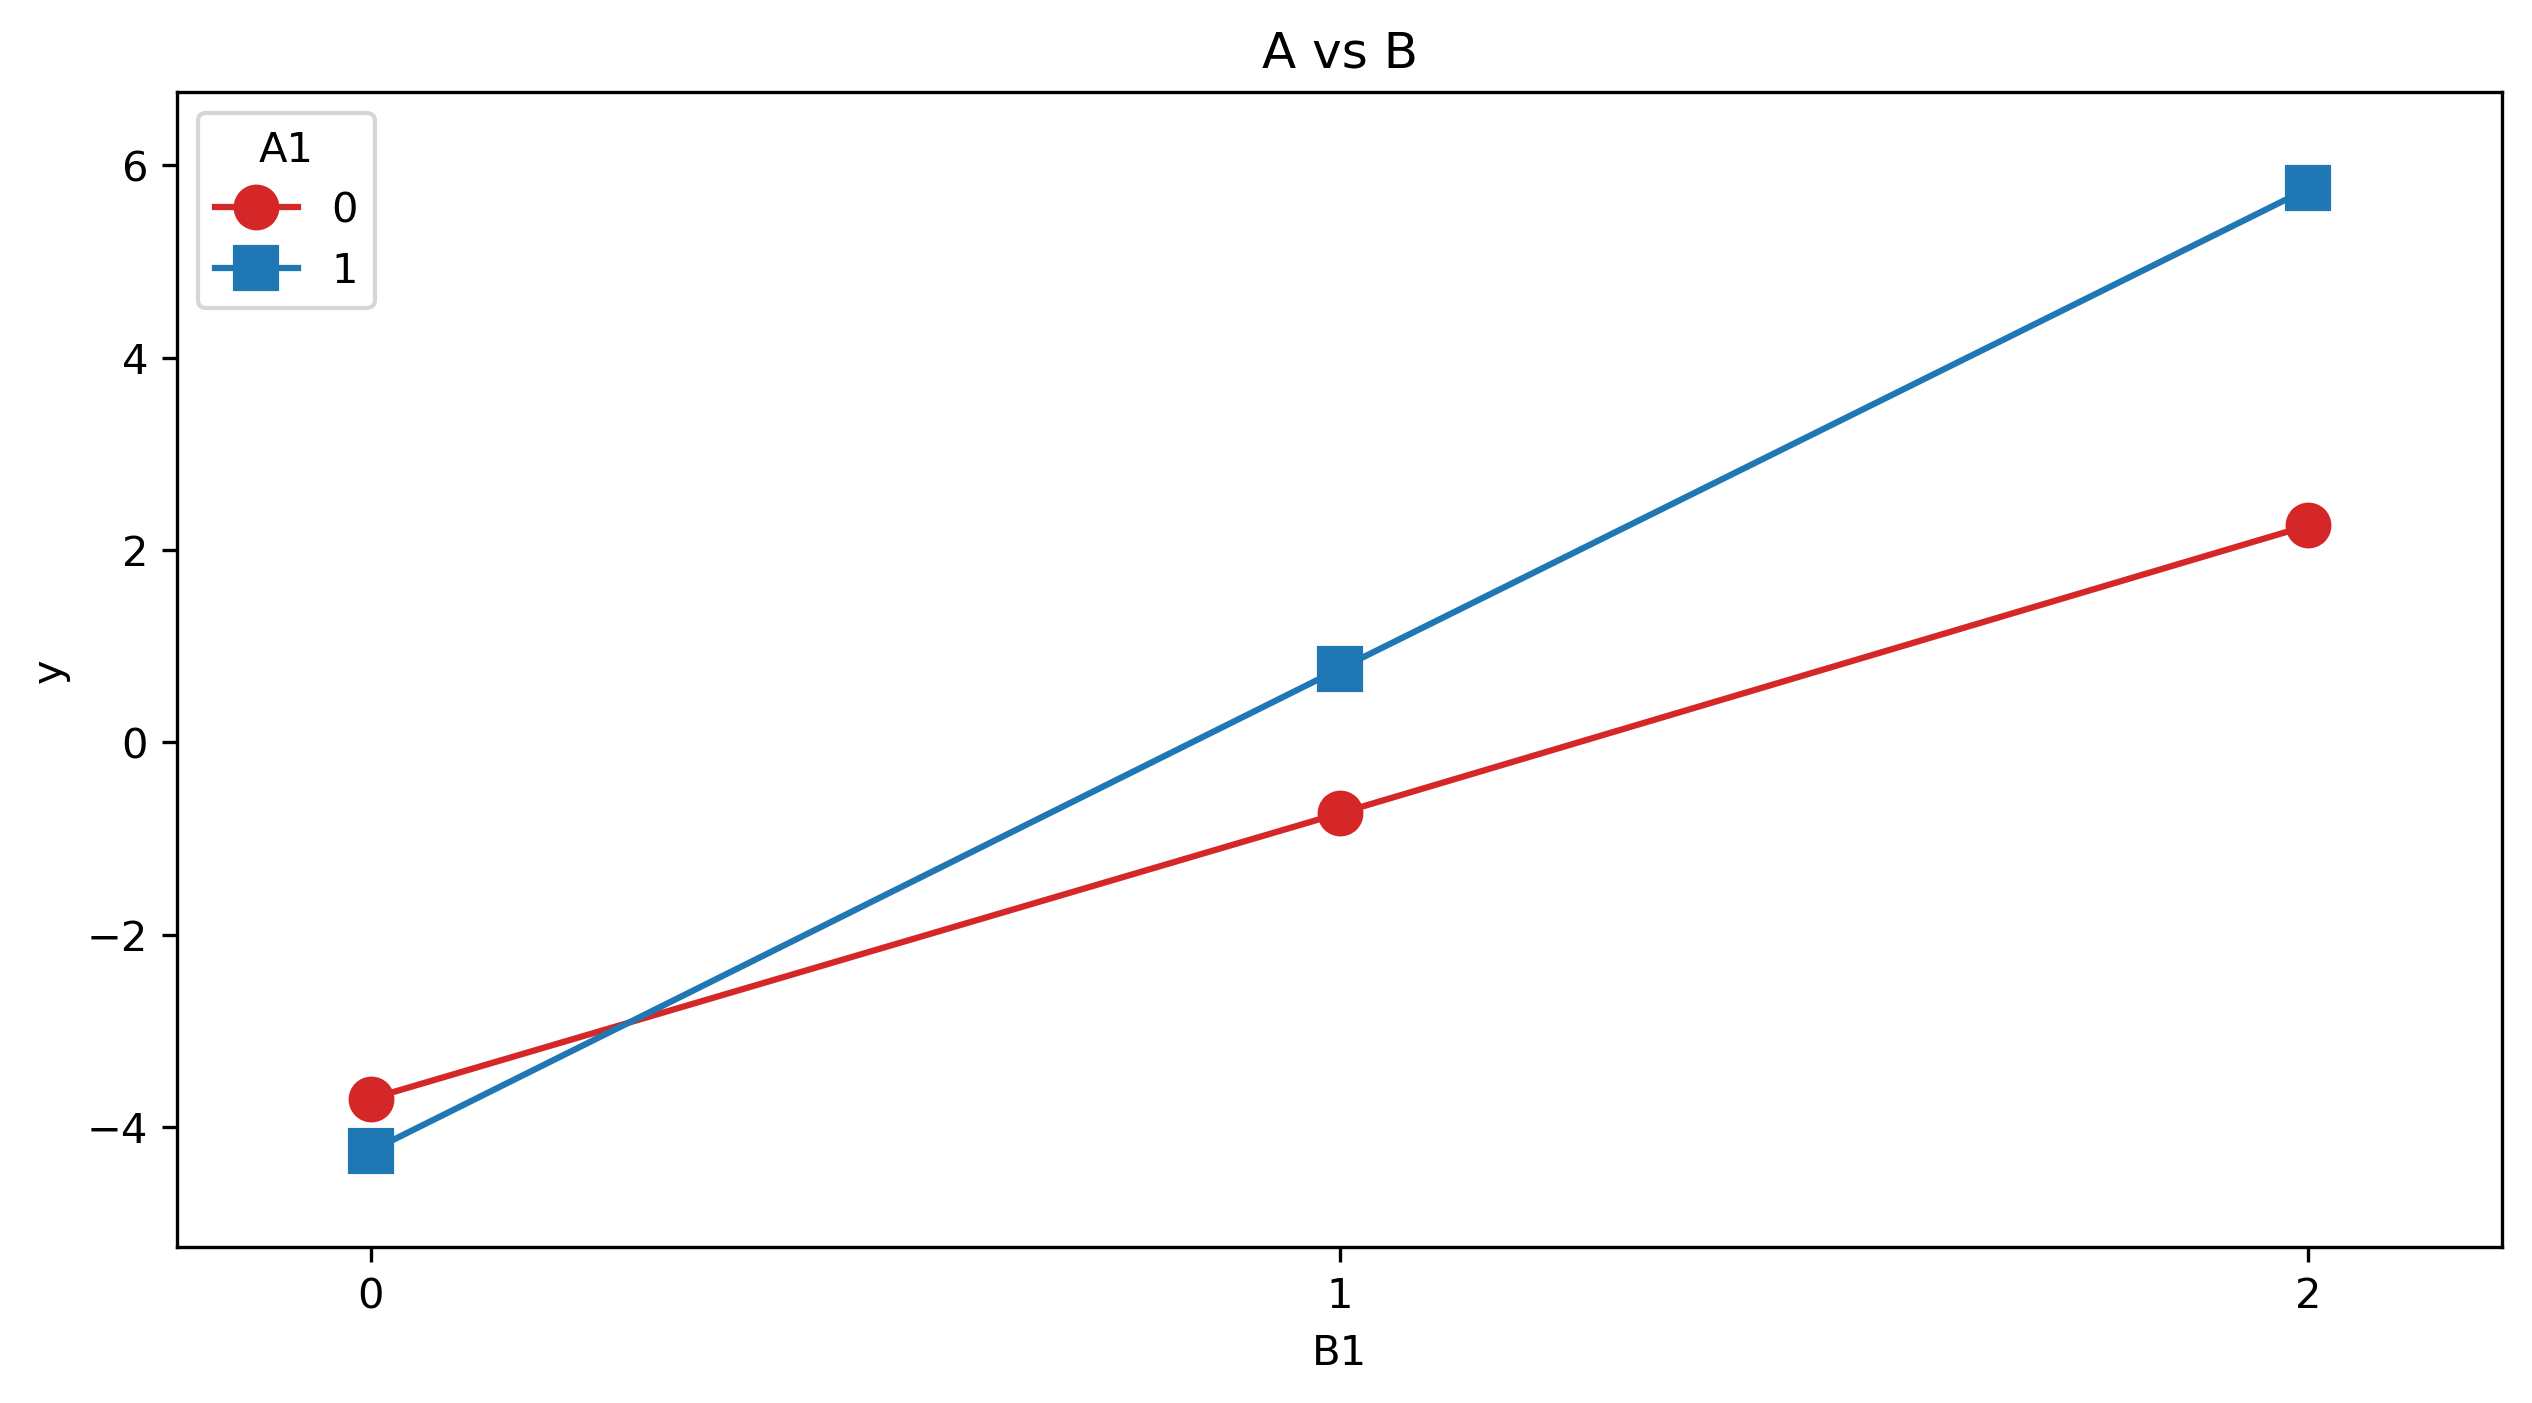

In [93]:
from statsmodels.graphics.factorplots import interaction_plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
interaction_plot(
    x = df['B1'],
    trace = df['A1'],
    response = df['y'],
    colors = ['tab:red', 'tab:blue'],
    markers = ['o', 's'],
    ms = 10,
    ax = ax
)
ax.set_xlabel('B1')
ax.set_ylabel('y')
ax.set_title('A vs B')
ax.set_xticks(df['B1'].unique())

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:131: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



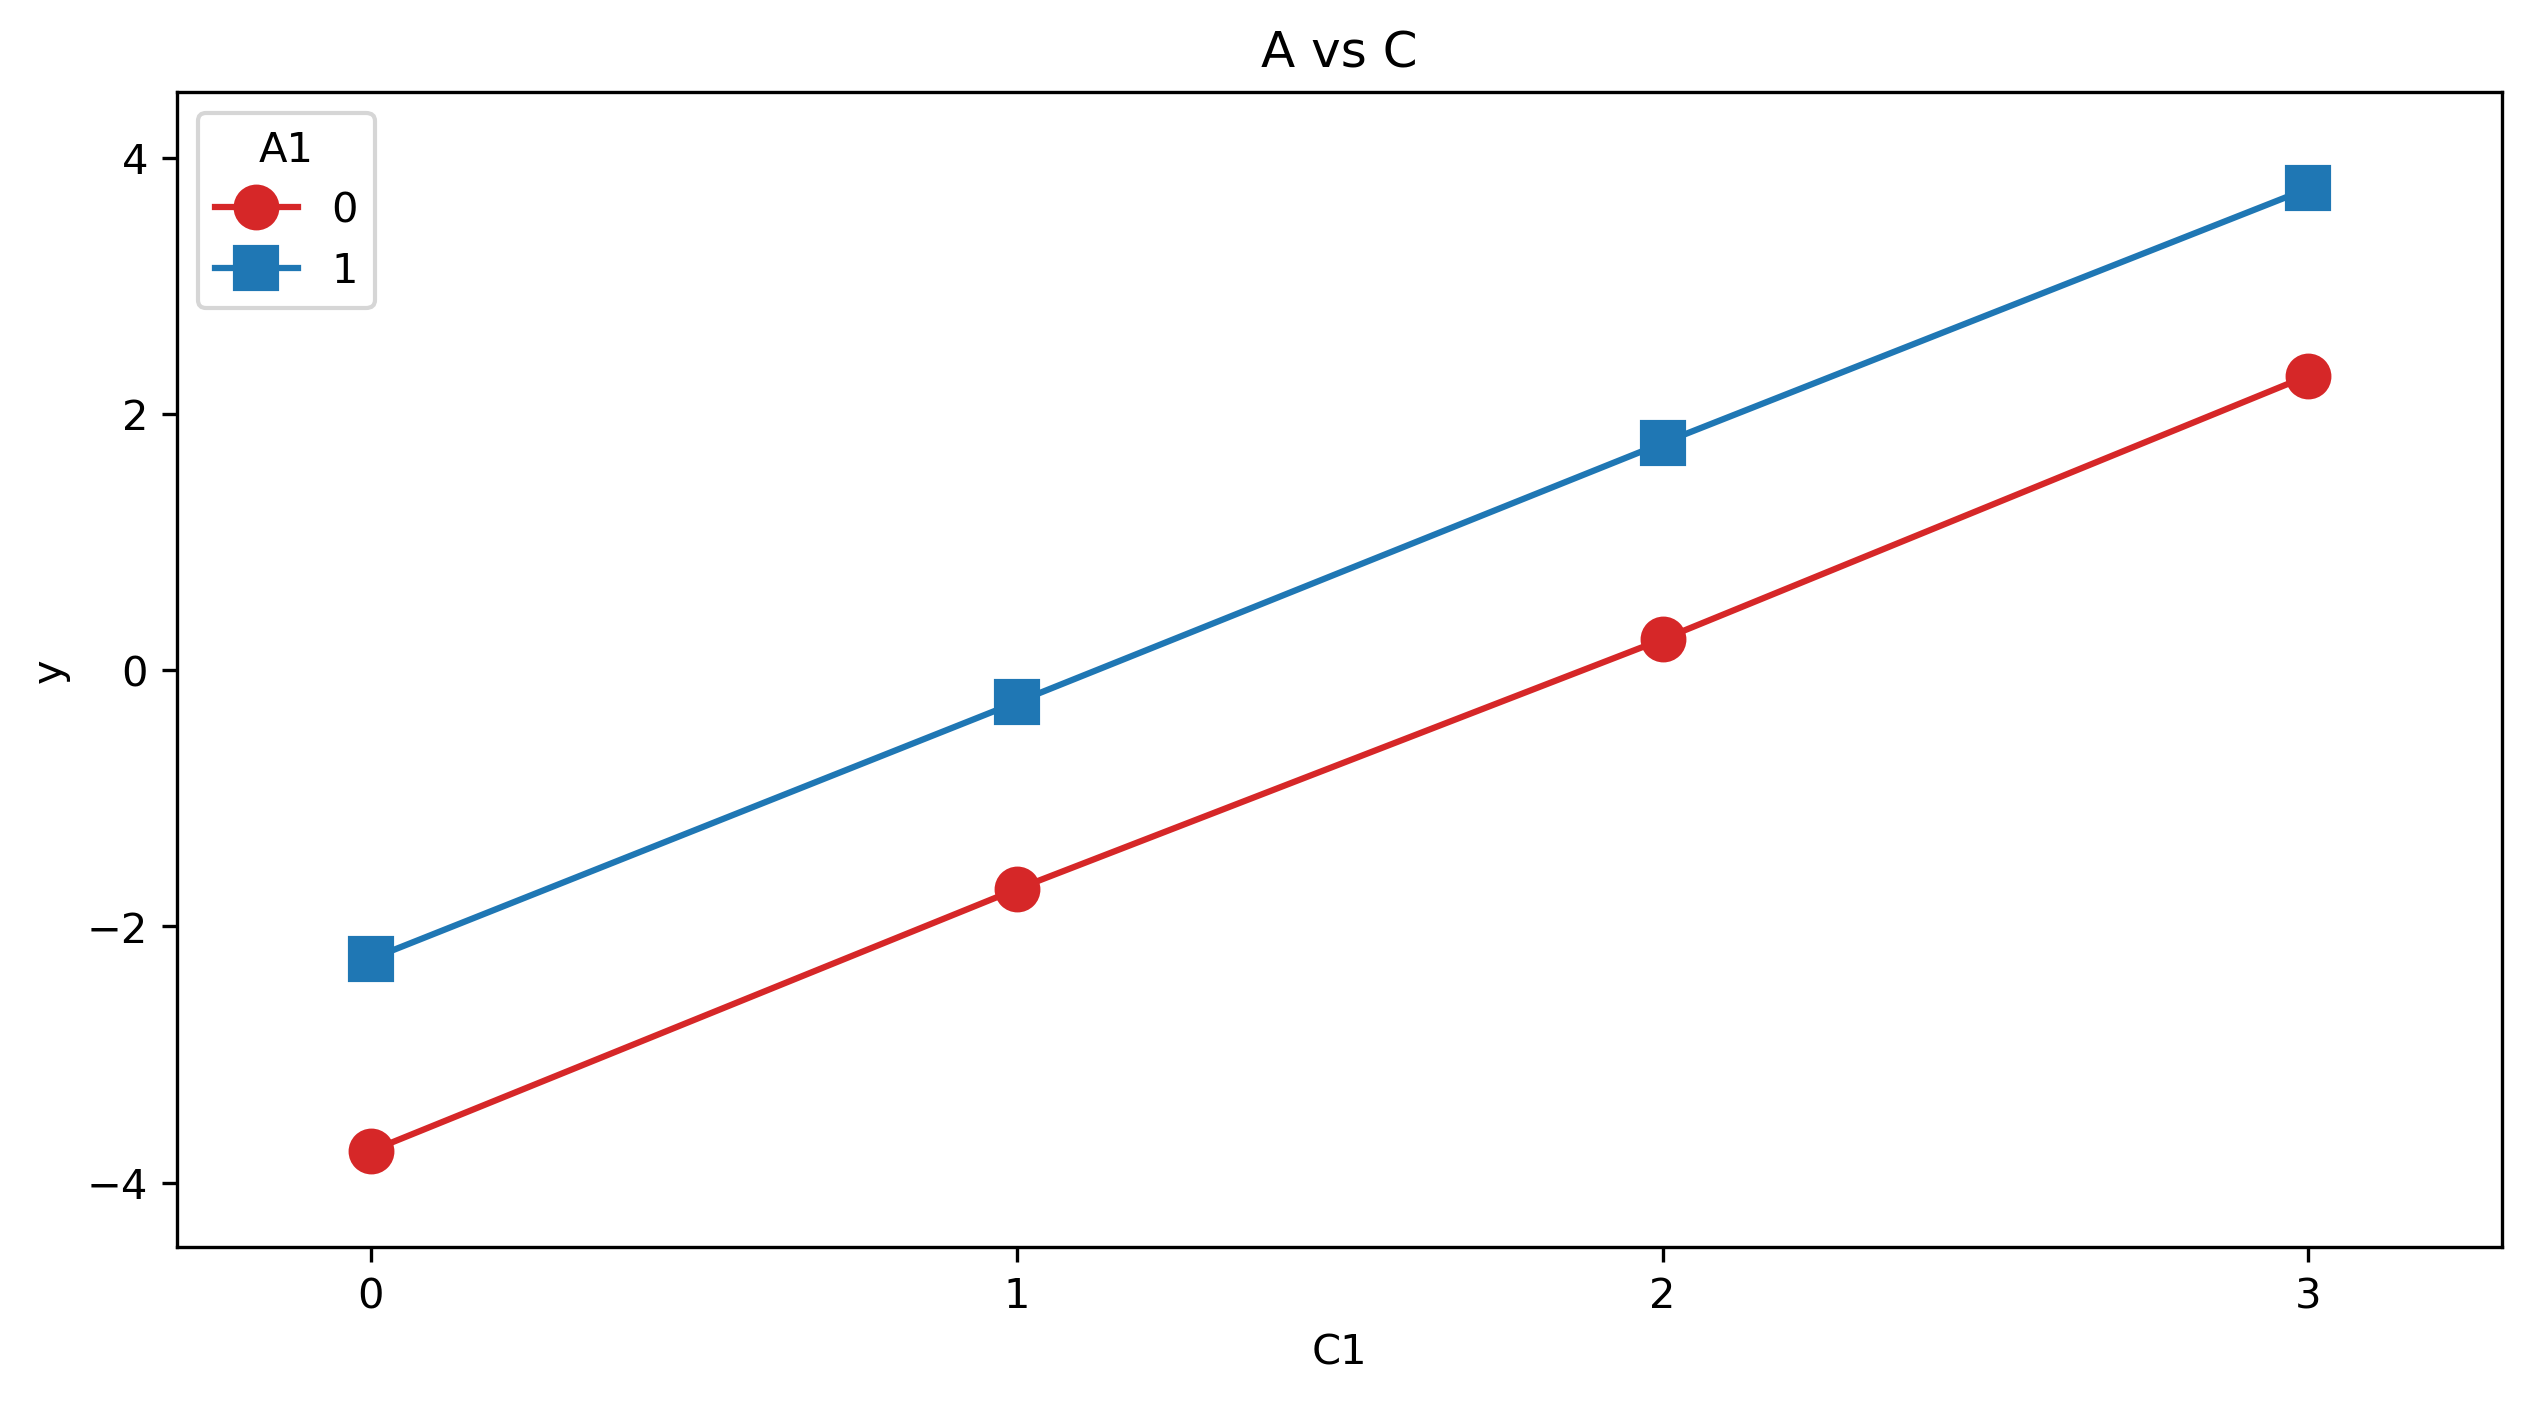

In [94]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
interaction_plot(
    x = df['C1'],
    trace = df['A1'],
    response = df['y'],
    colors = ['tab:red', 'tab:blue'],
    markers = ['o', 's'],
    ms = 10,
    ax = ax
)
ax.set_xlabel('C1')
ax.set_ylabel('y')
ax.set_title('A vs C')
ax.set_xticks(df['C1'].unique())

## Análisis de Varianza
> Realice un análisis de varianza (ANOVA) sobre los datos generados. ¿Qué concluye respecto a los efectos principales e interacciones? ¿Cuál efecto resulta ser más significativo? Recuerde verificar la normalidad de los residuos y su homocedasticidad.

El análisis de varianza en este caso, nos va a permitir estimar si existe o no significancia en el efecto que puedan tener los diferentes tratamientos y sus interacciones en el modelo. 

In [96]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm

ols_model = ols('y ~ A1 * B1 * C1', data = df).fit()
anova = anova_lm(ols_model, typ=2)
anova.round(5) # para que se vean mejor los p-values

,sum_sq,df,F,PR(>F)
A1,39.83486,1.0,5217.82077,0.00000
B1,765.19521,2.0,50115.04341,0.00000
C1,363.10710,3.0,15854.01799,0.00000
A1:B1,49.17591,2.0,3220.68535,0.00000
A1:C1,0.01633,3.0,0.71314,0.54895
B1:C1,38.71419,6.0,845.17143,0.00000
A1:B1:C1,960.58998,6.0,20970.68734,0.00000
Residual,0.36645,48.0,NaN,NaN


Luego, es necesario analizar los residuos del modelo para evaluar la confianza en la prueba realizada.

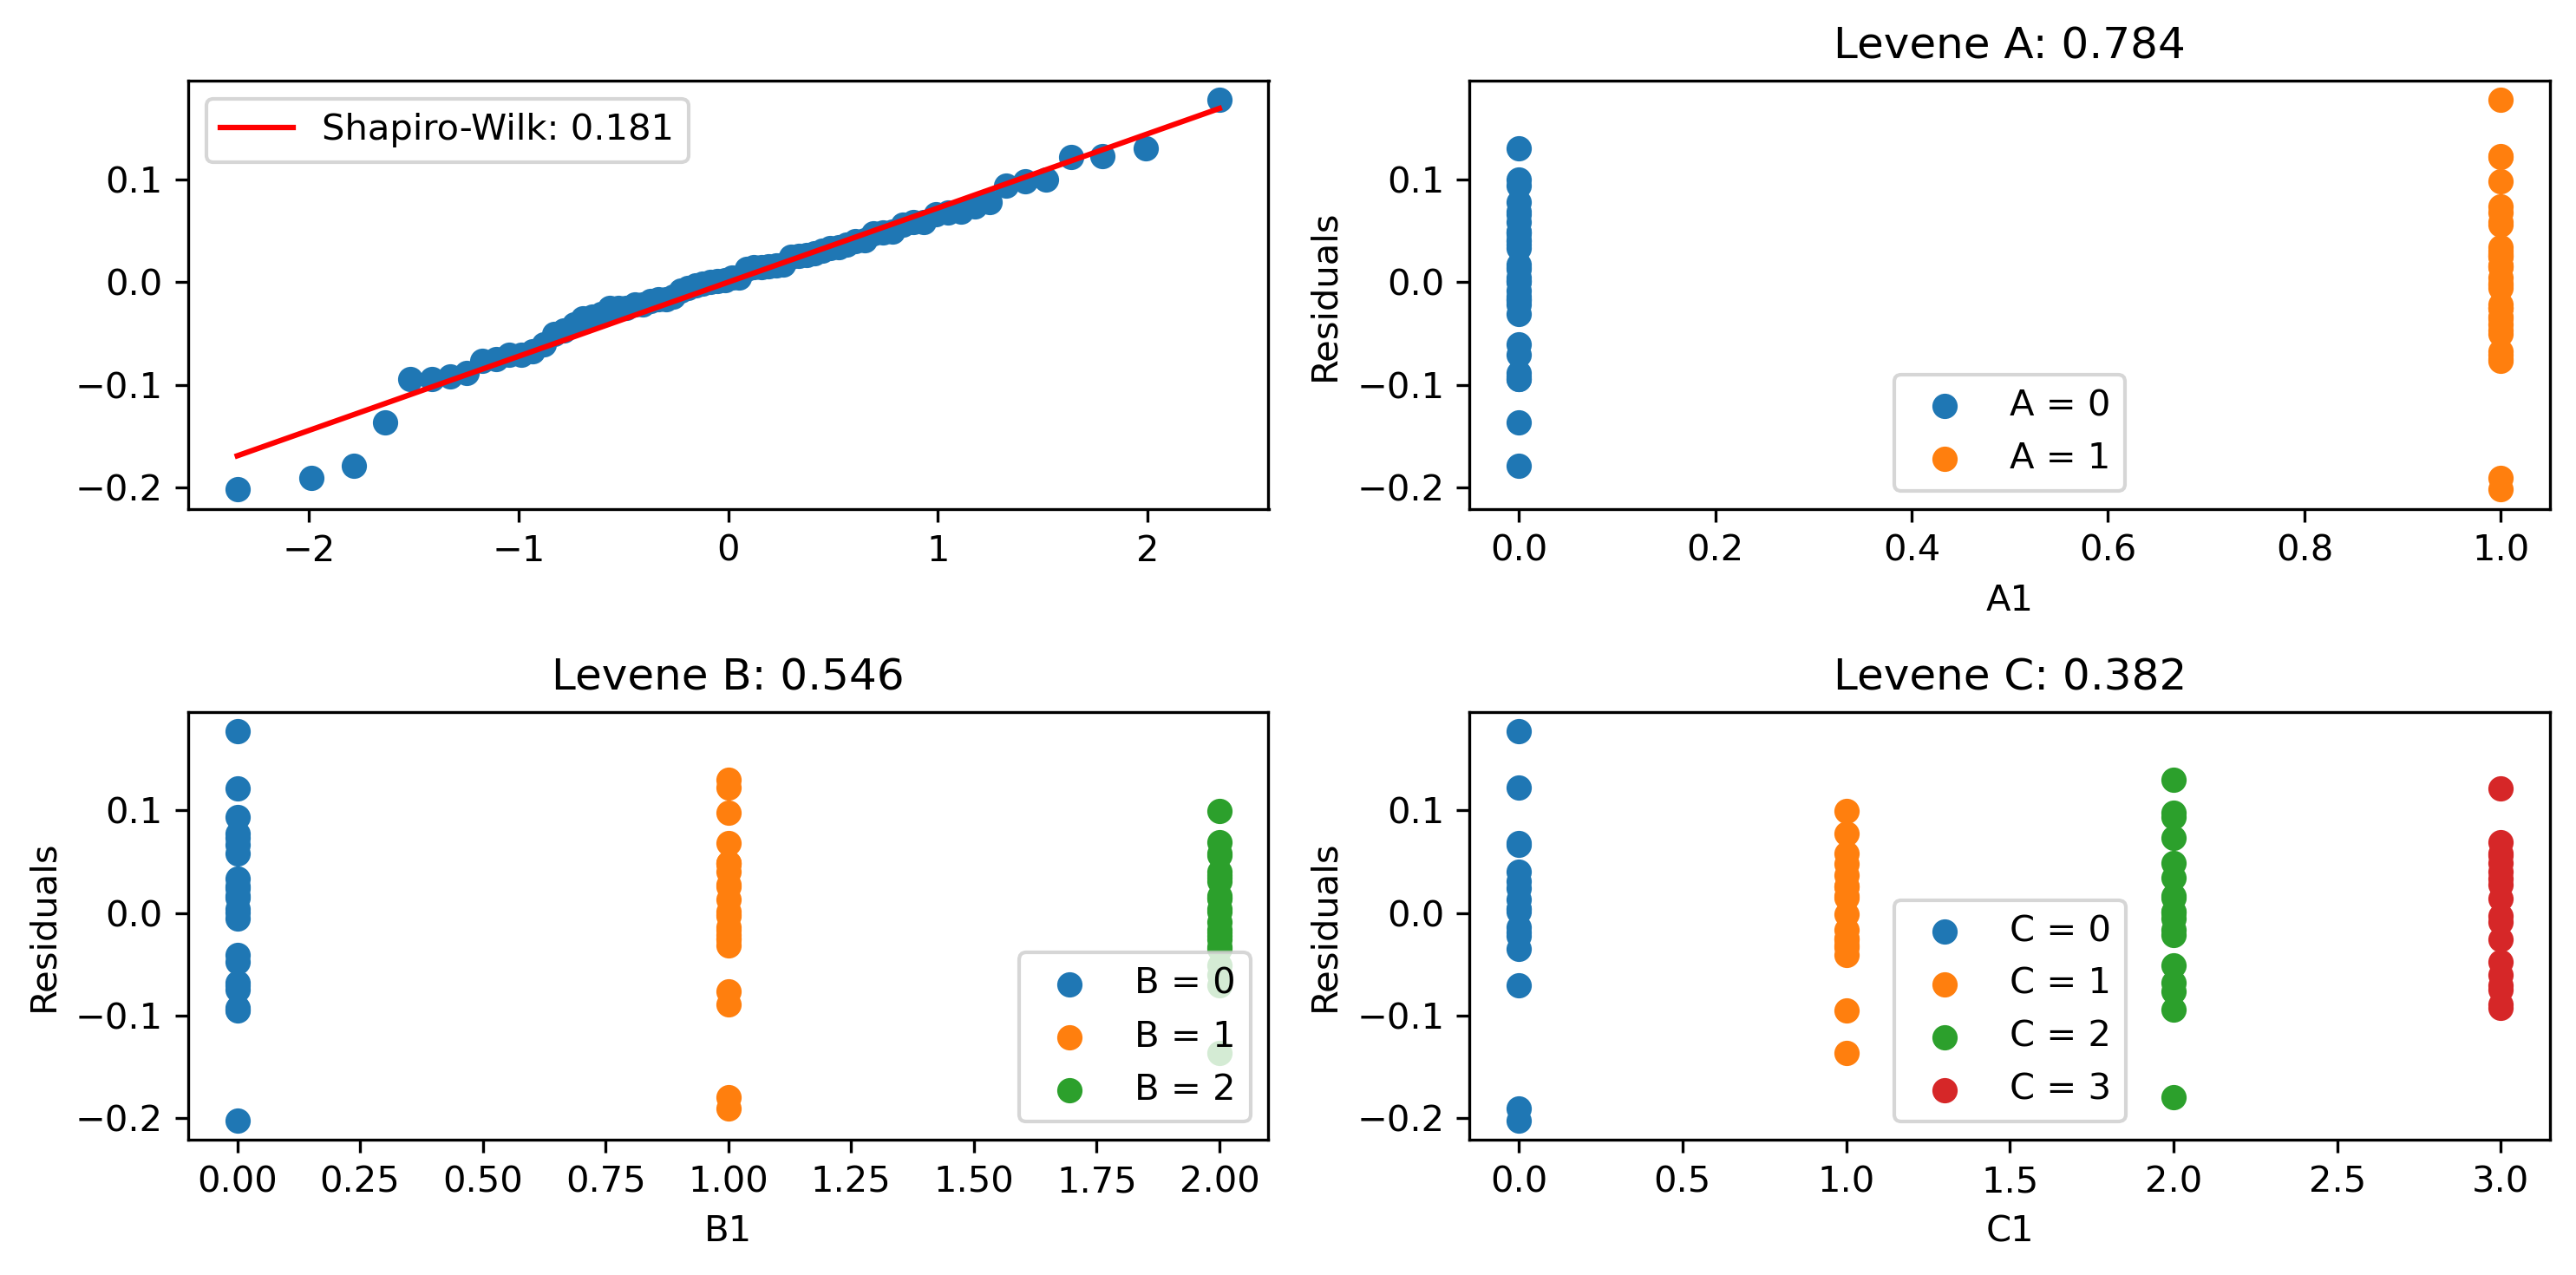

In [97]:
residuals = ols_model.resid
fig, ax = plt.subplots(2, 2, figsize=(10, 5), dpi = 300)
(osm, osr) , (slope, intercept, r) = stats.probplot(residuals, dist = "norm")
shapiro_wilk = stats.shapiro(residuals)[1]
ax[0,0].scatter(osm, osr)
ax[0,0].plot(osm, slope * osm + intercept, color = 'red', label = f'Shapiro-Wilk: {shapiro_wilk:.3f}')
ax[0,0].legend()
for i in df['A1'].unique():
    resid_a = residuals[df['A1'] == i]
    ax[0,1].scatter(i * np.ones(len(resid_a)), resid_a, label = f'A = {i}')
    
levene_A = stats.levene(residuals[df['A1'] == 0], residuals[df['A1'] == 1])[1]
ax[0,1].set_xlabel('A1')
ax[0,1].set_ylabel('Residuals')
ax[0,1].set_title('Residuals vs A')
ax[0,1].set_title(f'Levene A: {levene_A:.3f}')
ax[0,1].legend()

for i in df['B1'].unique():
    resid_b = residuals[df['B1'] == i]
    ax[1,0].scatter(i * np.ones(len(resid_b)), resid_b, label = f'B = {i}')
levene_B = stats.levene(residuals[df['B1'] == 0], residuals[df['B1'] == 1])[1]
ax[1,0].set_xlabel('B1')
ax[1,0].legend()
ax[1,0].set_ylabel('Residuals')
ax[1,0].set_title('Residuals vs B')
ax[1,0].set_title(f'Levene B: {levene_B:.3f}')
for i in df['C1'].unique():
    resid_c = residuals[df['C1'] == i]
    ax[1,1].scatter(i * np.ones(len(resid_c)), resid_c, label = f'C = {i}')
levene_C = stats.levene(residuals[df['C1'] == 0], residuals[df['C1'] == 1])[1]
ax[1,1].set_xlabel('C1')
ax[1,1].set_ylabel('Residuals')
ax[1,1].set_title('Residuals vs C')
ax[1,1].set_title(f'Levene C: {levene_C:.3f}')
ax[1,1].legend()


fig.tight_layout()

Entonces, se complen los supuestos de normalidad y homocedasticidad entre condiciones considerando las diferentes situaciones experimentales.

## Estimación de Efectos

> Estime los efectos principales e interacciones. ¿Cuál variable o interacción posee el mayor efecto sobre la respuesta?

Al igual que como estudiamos los efectos de variables continuas a la hora de estimar un modelo lineal. Es posible realizar el mismo procedimiento para variables categóricas. Este tipo de modelos se denominan modelos de efecto fijo, debido a que cada condición posee un efecto fijo. 

Para poder estimar los efectos de los diferentes factores, es necesario aislar los efectos de los factores. 

Este tipo de modelos tienen la forma:
$$
y_{ijkl} = \mu + \tau_i + \beta_j + \gamma_k + (\tau \beta)_{ij} + (\tau \gamma)_{jk} + (\beta \gamma)_{ik} + (\tau \beta \gamma)_{ijk} + \epsilon_{ijkl}
$$

Para los casos de dos variables, estos se cálculan como:

$$
\widehat{\mu} = \mathbb{E}[y_{\cdot\cdot\cdot}]
$$
$$
\widehat{\tau}_i = \mathbb{E}[y_{i\cdot \cdot}] - \mathbb{E}[y_{\cdot\cdot\cdot}]
$$
$$
\widehat{\beta}_j = \mathbb{E}[y_{\cdot j \cdot}] - \mathbb{E}[y_{\cdot\cdot\cdot}]
$$
$$
\widehat{\left( \tau \beta \right)}_{ij} = \mathbb{E}[y_{i j \cdot }] - (\mathbb{E}[y_{i\cdot \cdot}] - \mathbb{E}[y_{\cdot\cdot\cdot}]) - (\mathbb{E}[y_{\cdot j \cdot}] - \mathbb{E}[y_{\cdot\cdot\cdot}]) - \mathbb{E}[y_{\cdot\cdot\cdot}]
$$
$$
\widehat{\left( \tau \beta \right)}_{ij} = \mathbb{E}[y_{i j \cdot }] - \mathbb{E}[y_{i\cdot \cdot}] - \mathbb{E}[y_{\cdot j \cdot}] - \mathbb{E}[y_{\cdot\cdot\cdot}]
$$

Y así, podemos generalizar para los otros casos al darnos cuenta que estámos aislando de forma sistemática el efecto de los diferentes factores. 

In [148]:
### Evaluemos

mu = df["y"].mean()

A_means = df.groupby("A1", observed=True)["y"].mean()
B_means = df.groupby("B1", observed=True)["y"].mean()
C_means = df.groupby("C1", observed=True)["y"].mean()

AB_means = df.groupby(["A1", "B1"], observed= True)["y"].mean()
AC_means = df.groupby(["A1", "C1"], observed=True)["y"].mean()
BC_means = df.groupby(["B1", "C1"], observed=True)["y"].mean()

ABC_means = df.groupby(["A1", "B1", "C1"], observed=True)["y"].mean()

In [158]:
factor_A = A_means - mu
factor_B = B_means - mu   
factor_C = C_means - mu
interactions_AB = (
    AB_means
    - A_means
    - B_means
    + mu
)
interactions_AC = (
    AC_means
    - A_means
    - C_means
    + mu
)
interactions_BC = (
    BC_means
    - B_means
    - C_means
    + mu
)

interaction_3way = (
    ABC_means
    - AB_means.unstack().stack()
    - AC_means.unstack().stack()
    - BC_means.unstack().stack()
    + A_means
    + B_means
    + C_means
    - mu
)
print('Grand Mean')
display(mu)
print('Factor A')
display(factor_A)
print('Factor B')
display(factor_B)
print('Factor C')
display(factor_C)
print('Interaction AB')
display(interactions_AB)
print('Interaction AC')
display(interactions_AC)
print('Interaction BC')
display(interactions_BC)
print('Interaction ABC')
display(interaction_3way)


        

Grand Mean


np.float64(0.3878051586541603)

Factor A


A1
1    0.689615
2   -0.117568
3   -0.572047
Name: y, dtype: float64

Factor B


B1
1    0.272214
2   -0.293154
Name: y, dtype: float64

Factor C


C1
1    0.272214
2   -0.293154
Name: y, dtype: float64

Interaction AB


A1  B1
1   1    -0.138034
    2     0.125429
2   1     0.550078
    2    -0.364680
3   1    -0.325542
    2     0.359814
Name: y, dtype: float64

Interaction AC


A1  C1
1   1    -0.138034
    2     0.125429
2   1     0.550078
    2    -0.364680
3   1    -0.325542
    2     0.359814
Name: y, dtype: float64

Interaction BC


B1  C1
1   1    -0.272214
2   2     0.293154
Name: y, dtype: float64

Interaction ABC


A1  B1  C1
1   1   1     0.138034
2   1   1    -0.550078
3   1   1     0.325542
1   2   2    -0.125429
2   2   2     0.364680
3   2   2    -0.359814
dtype: float64

# Parte 2: Diseño Factorial por Bloques

Suponga ahora que la variable $x_3$ representa una **variable de bloqueo**, es decir, una fuente sistemática de variabilidad no relacionada con los factores de interés. Se modela de la misma manera, pero con coeficientes distintos:

$$
    y = 1.5 + w_1x_1 + w_2x_2 + w_3x_3 + w_{1,2} x_1x_2 + w_{1,3} x_1x_3 + w_{2,3} x_2x_3  + w_{1,2,3}x_1x_2x_3
$$



In [236]:
matriz_diseno = fullfact([2,3,4])

matriz_diseno = pd.DataFrame(np.repeat(matriz_diseno, 3, axis=0), columns=['A1', 'B1', 'Bloque'])
matriz_diseno['Rep'] = np.tile(np.arange(1, 4), len(matriz_diseno) // 3)
matriz_diseno = matriz_diseno.astype('int').astype('category')

# pesos
weights = {
    "w1": 0.5,
    "w2": 4,
    "w3": 0.04,
    "w1_2": 3,
    "w1_3": 0.01,
    "w2_3": 0.09,
    "w1_2_3": 1
}

matriz_cont = matriz_diseno.copy()
matriz_cont = matriz_cont.apply(lambda x: minmax_scale(x, feature_range=(-1, 1)))

y = (
    1.5 * matriz_cont['A1'] * weights['w1']
    + matriz_cont['B1'] * weights['w2']
    + matriz_cont['Bloque'] * weights['w3']
    + matriz_cont['A1'] * matriz_cont['B1'] * weights['w1_2']
    + matriz_cont['A1'] * matriz_cont['Bloque'] * weights['w1_3']
    + matriz_cont['B1'] * matriz_cont['Bloque'] * weights['w2_3']
    + matriz_cont['A1'] * matriz_cont['B1'] * matriz_cont['Bloque'] * weights['w1_2_3']
    + np.random.normal(0, 0.01, len(matriz_diseno))
)
matriz_diseno['y'] = y
matriz_cont['y'] = y


## Análisis exploratorio

> A partir del nuevo modelo, grafique las curvas de respuesta entre $x_1$, $x_2$ y $y$. ¿Existe interacción entre $x_1$ y $x_2$?

En este caso, generamos curvas de respuesta por bloque.


In [172]:
surfaces = []

for i in matriz_diseno['Bloque'].unique():
    xi = np.linspace(-1, 1, 100)
    yi = np.linspace(-1, 1, 100)
    zi = 0

    xi, yi = np.meshgrid(xi, yi)
    response = (
        1.5 * xi * weights['w1']
        + yi * weights['w2']
        + i * weights['w3']
        + xi * yi * weights['w1_2']
        + xi * i * weights['w1_3']
        + yi * i * weights['w2_3']
        + xi * yi * i * weights['w1_2_3']
    )
    surfaces.append(go.Surface(x=xi, y=yi, z=response, name=f'Bloque {i}'))
fig = go.Figure(data=surfaces)
fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='response'
    ),
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    )
)
fig.update_traces(
    hoverinfo='none',
    showscale=False
)
fig.show()

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:131: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True

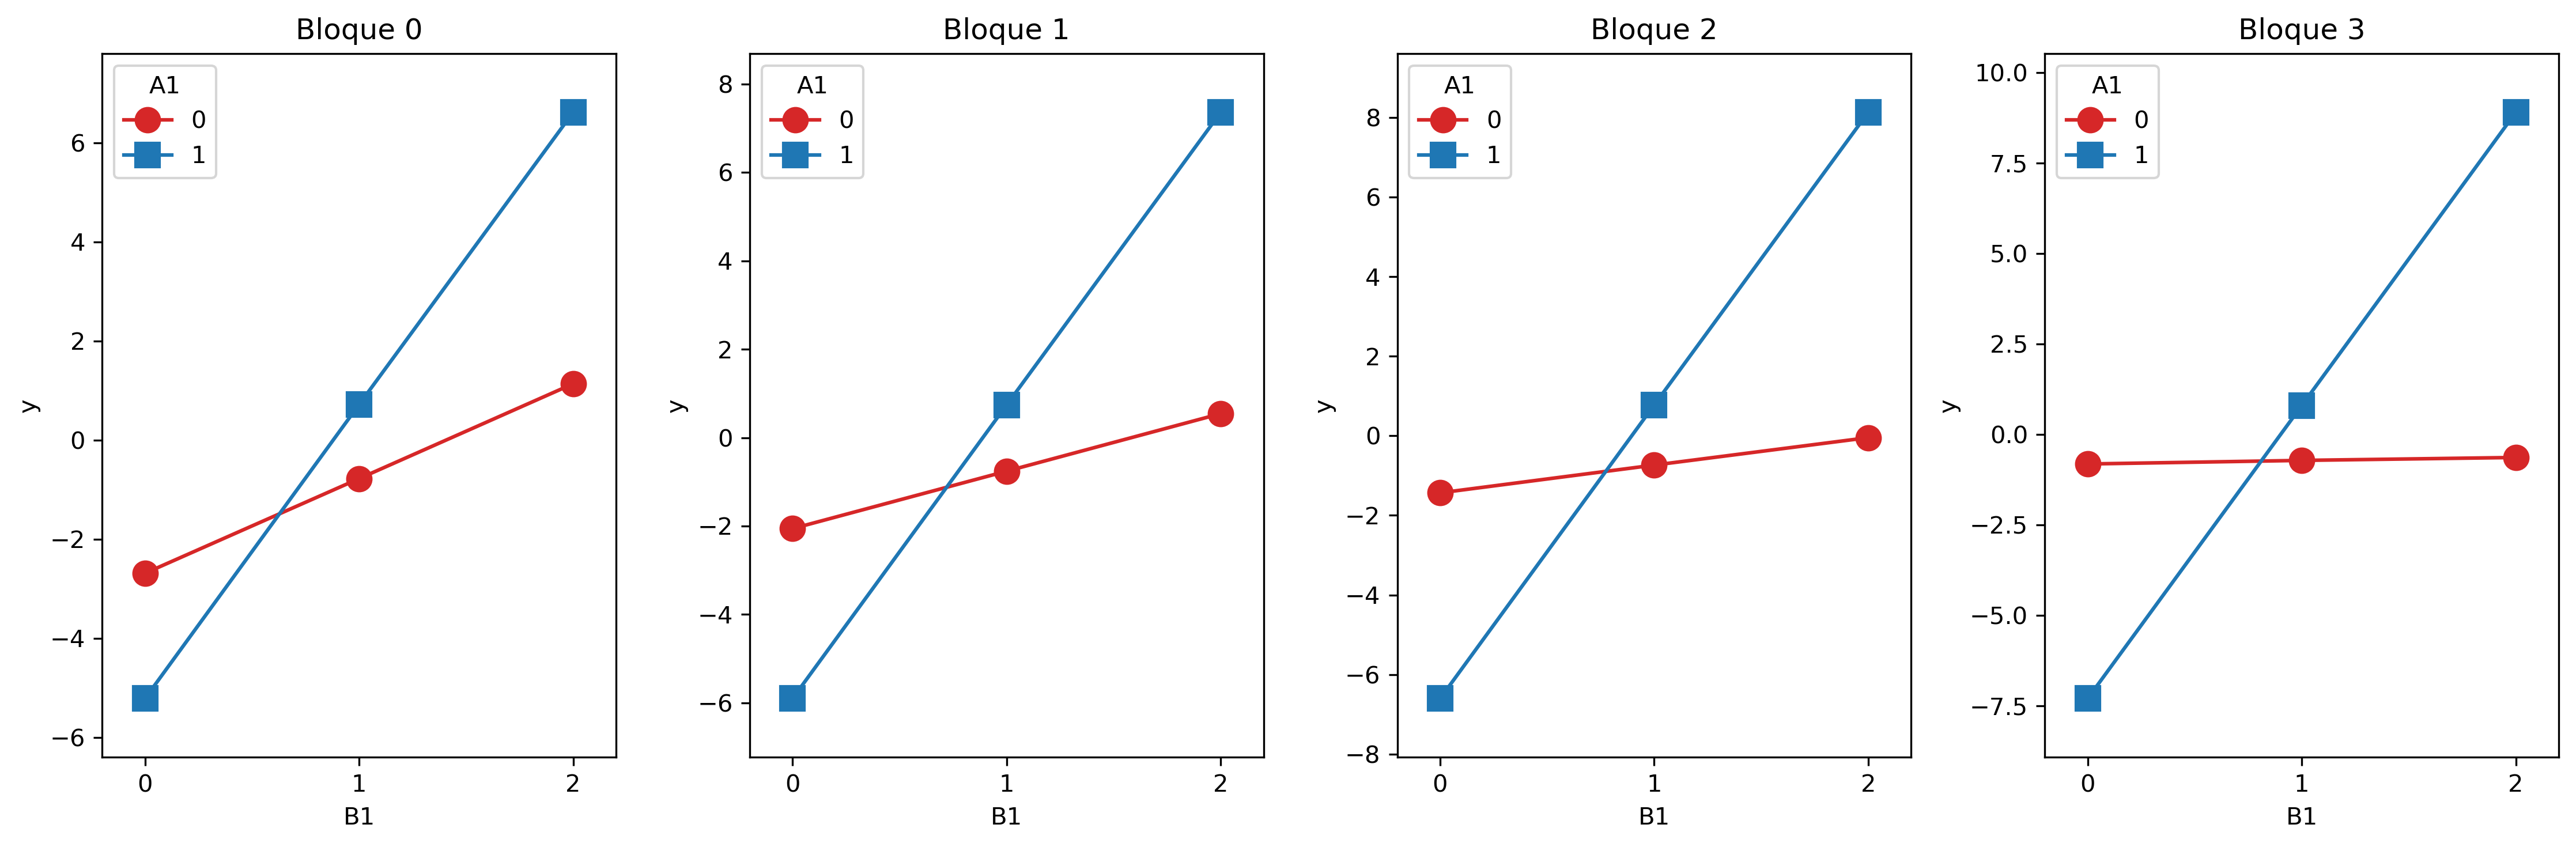

In [187]:
### interaction plot
fig, ax = plt.subplots(1, 4, figsize=(15, 5), dpi = 300)
for i in matriz_diseno['Bloque'].unique():
    x = matriz_diseno['B1'][matriz_diseno['Bloque'] == i].values
    trace = matriz_diseno['A1'][matriz_diseno['Bloque'] == i].values
    response = matriz_diseno['y'][matriz_diseno['Bloque'] == i]
    # print(trace)
    # print(x)
    interaction_plot(
        x = x,
        trace = trace,
        response = response,
        colors = ['tab:red', 'tab:blue'],
        markers = ['o', 's'],
        ms = 10,
        ax = ax[i]
    )
    ax[i].set_xlabel('B1')
    ax[i].set_ylabel('y')
    ax[i].set_title(f'Bloque {i}')
    ax[i].set_xticks(matriz_diseno['B1'].unique())
    ax[i].set_xticklabels(matriz_diseno['B1'].unique())
    ax[i].legend(title='A1', loc='upper left')
fig.tight_layout()
plt.show()

## ANOVA por bloques

> Realice un nuevo análisis de varianza. ¿Cuál es el efecto del bloque $x_3$ sobre la respuesta? ¿Cómo afecta la varianza del modelo?

Consideremos el caso sin replicaciones.

In [ ]:
rep1 = matriz_diseno[matriz_diseno['Rep'] == 1].drop(columns=['Rep'])

In [229]:
def anova_2f_block(df, var1 = None, var2 = None, y = None, block = None):
    """
    df: dataframe
    var1: variable 1
    var2: variable 2
    block: bloque
    """
    
    if var1 is None or var2 is None or y is None or block is None:
        raise ValueError("var1, var2, y and block must be defined")
    grand_sum = df[y].sum()
    
    sum_A = df.groupby(var1)[y].sum()
    sum_B = df.groupby(var2)[y].sum()
    sum_AB = df.groupby([var1, var2])[y].sum()
    sum_blocks = df.groupby(block)[y].sum()
    
    a = len(df[var1].unique())
    b = len(df[var2].unique())
    n = len(df[block].unique())
    
    mean_sum_sq = grand_sum**2 / (a*b*n) # si
    
    sum_of_squares_A = (1 / (b * n) ) * (sum_A**2).sum() - mean_sum_sq
    sum_of_squares_B = (1 /( a * n) ) * (sum_B**2).sum() - mean_sum_sq
    sum_subtotals = (1 / n ) * (sum_AB**2).sum() - mean_sum_sq
    sum_of_squares_AB = sum_subtotals - sum_of_squares_A - sum_of_squares_B
    sum_of_squares_block = (1 / (a * b)) * (sum_blocks**2).sum() - mean_sum_sq # Si
    sum_of_squares_total = np.sum(df[y] ** 2) - mean_sum_sq
    
    sum_of_squares_error = sum_of_squares_total - sum_of_squares_A - sum_of_squares_B - sum_of_squares_AB - sum_of_squares_block
    
    # Grados de libertad
    df_A = a - 1
    df_B = b - 1
    df_AB = (a - 1) * (b - 1)
    df_block = n - 1
    df_total = len(df) - 1
    df_error = (a * b - 1) * ( n - 1)
    # MS
    MS_A = sum_of_squares_A / df_A
    MS_B = sum_of_squares_B / df_B
    MS_AB = sum_of_squares_AB / df_AB
    MS_block = sum_of_squares_block / df_block
    MS_error = sum_of_squares_error / df_error
    MS_T = sum_of_squares_total / df_total
    # F
    F_A = MS_A / MS_error
    F_B = MS_B / MS_error
    F_AB = MS_AB / MS_error
    
    # p-values
    
    p_val_A = stats.f.sf(F_A, df_A, df_error)
    p_val_B = stats.f.sf(F_B, df_B, df_error)
    p_val_AB = stats.f.sf(F_AB, df_AB, df_error)
    
    results = pd.DataFrame(columns = ['Source', 'SS', 'df', 'MS', 'F', 'p-value'])
    
    # A
    results_A = pd.DataFrame({
        'Source': [var1],
        'SS': [sum_of_squares_A],
        'df': [df_A],
        'MS': [MS_A],
        'F': [F_A],
        'p-value': [p_val_A]
    })
    # B
    results_B = pd.DataFrame({
        'Source': [var2],
        'SS': [sum_of_squares_B],
        'df': [df_B],
        'MS': [MS_B],
        'F': [F_B],
        'p-value': [p_val_B]
    })
    # AB        
    results_AB = pd.DataFrame({
        'Source': [f'{var1}*{var2}'],
        'SS': [sum_of_squares_AB],
        'df': [df_AB],
        'MS': [MS_AB],
        'F': [F_AB],
        'p-value': [p_val_AB]
    })
    # Block
    results_block = pd.DataFrame({
        'Source': [block],
        'SS': [sum_of_squares_block],
        'df': [df_block],
        'MS': [MS_block],
        'F': ['-'],
        'p-value': ['-']
    })
    # Error
    results_error = pd.DataFrame({
        'Source': ['Error'],
        'SS': [sum_of_squares_error],
        'df': [df_error],
        'MS': [MS_error],
        'F': ['-'],
        'p-value': ['-']
    })
    # Total
    results_total = pd.DataFrame({
        'Source': ['Total'],
        'SS': [sum_of_squares_total],
        'df': [df_total],
        'MS': [MS_T],
        'F': ['-'],
        'p-value': ['-']
    })
    # Concatenate results
    results = pd.concat([results_A, results_B, results_AB, results_block, results_error, results_total], ignore_index=True)
    results = results.round(5)

    return results

anova_2f_block(rep1, var1 = 'A1', var2 = 'B1', y = 'y', block = 'Bloque')

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_50770/3642774841.py:13: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_50770/3642774841.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_50770/3642774841.py:15: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zv/p838yyl57rb2tlk802d5y

,Source,SS,df,MS,F,p-value
0,A1,13.48475,1,13.48475,22.655133,0.000253
1,B1,256.21849,2,128.10924,215.230712,0.0
2,A1*B1,143.78241,2,71.89120,120.781251,0.0
3,Bloque,0.02194,3,0.00731,-,-
4,Error,8.92827,15,0.59522,-,-
5,Total,422.43586,23,18.36678,-,-


# Parte 3: Análsis estadístico clásico

> Visualice la curva de respuesta con el nuevo modelo reducido (sin $x_3$). Comente cualquier cambio observado.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:113: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/Users/gabrielmiranda/micromamba/envs/SaaLab/lib/python3.9/site-packages/statsmodels/graphics/factorplots.py:131: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



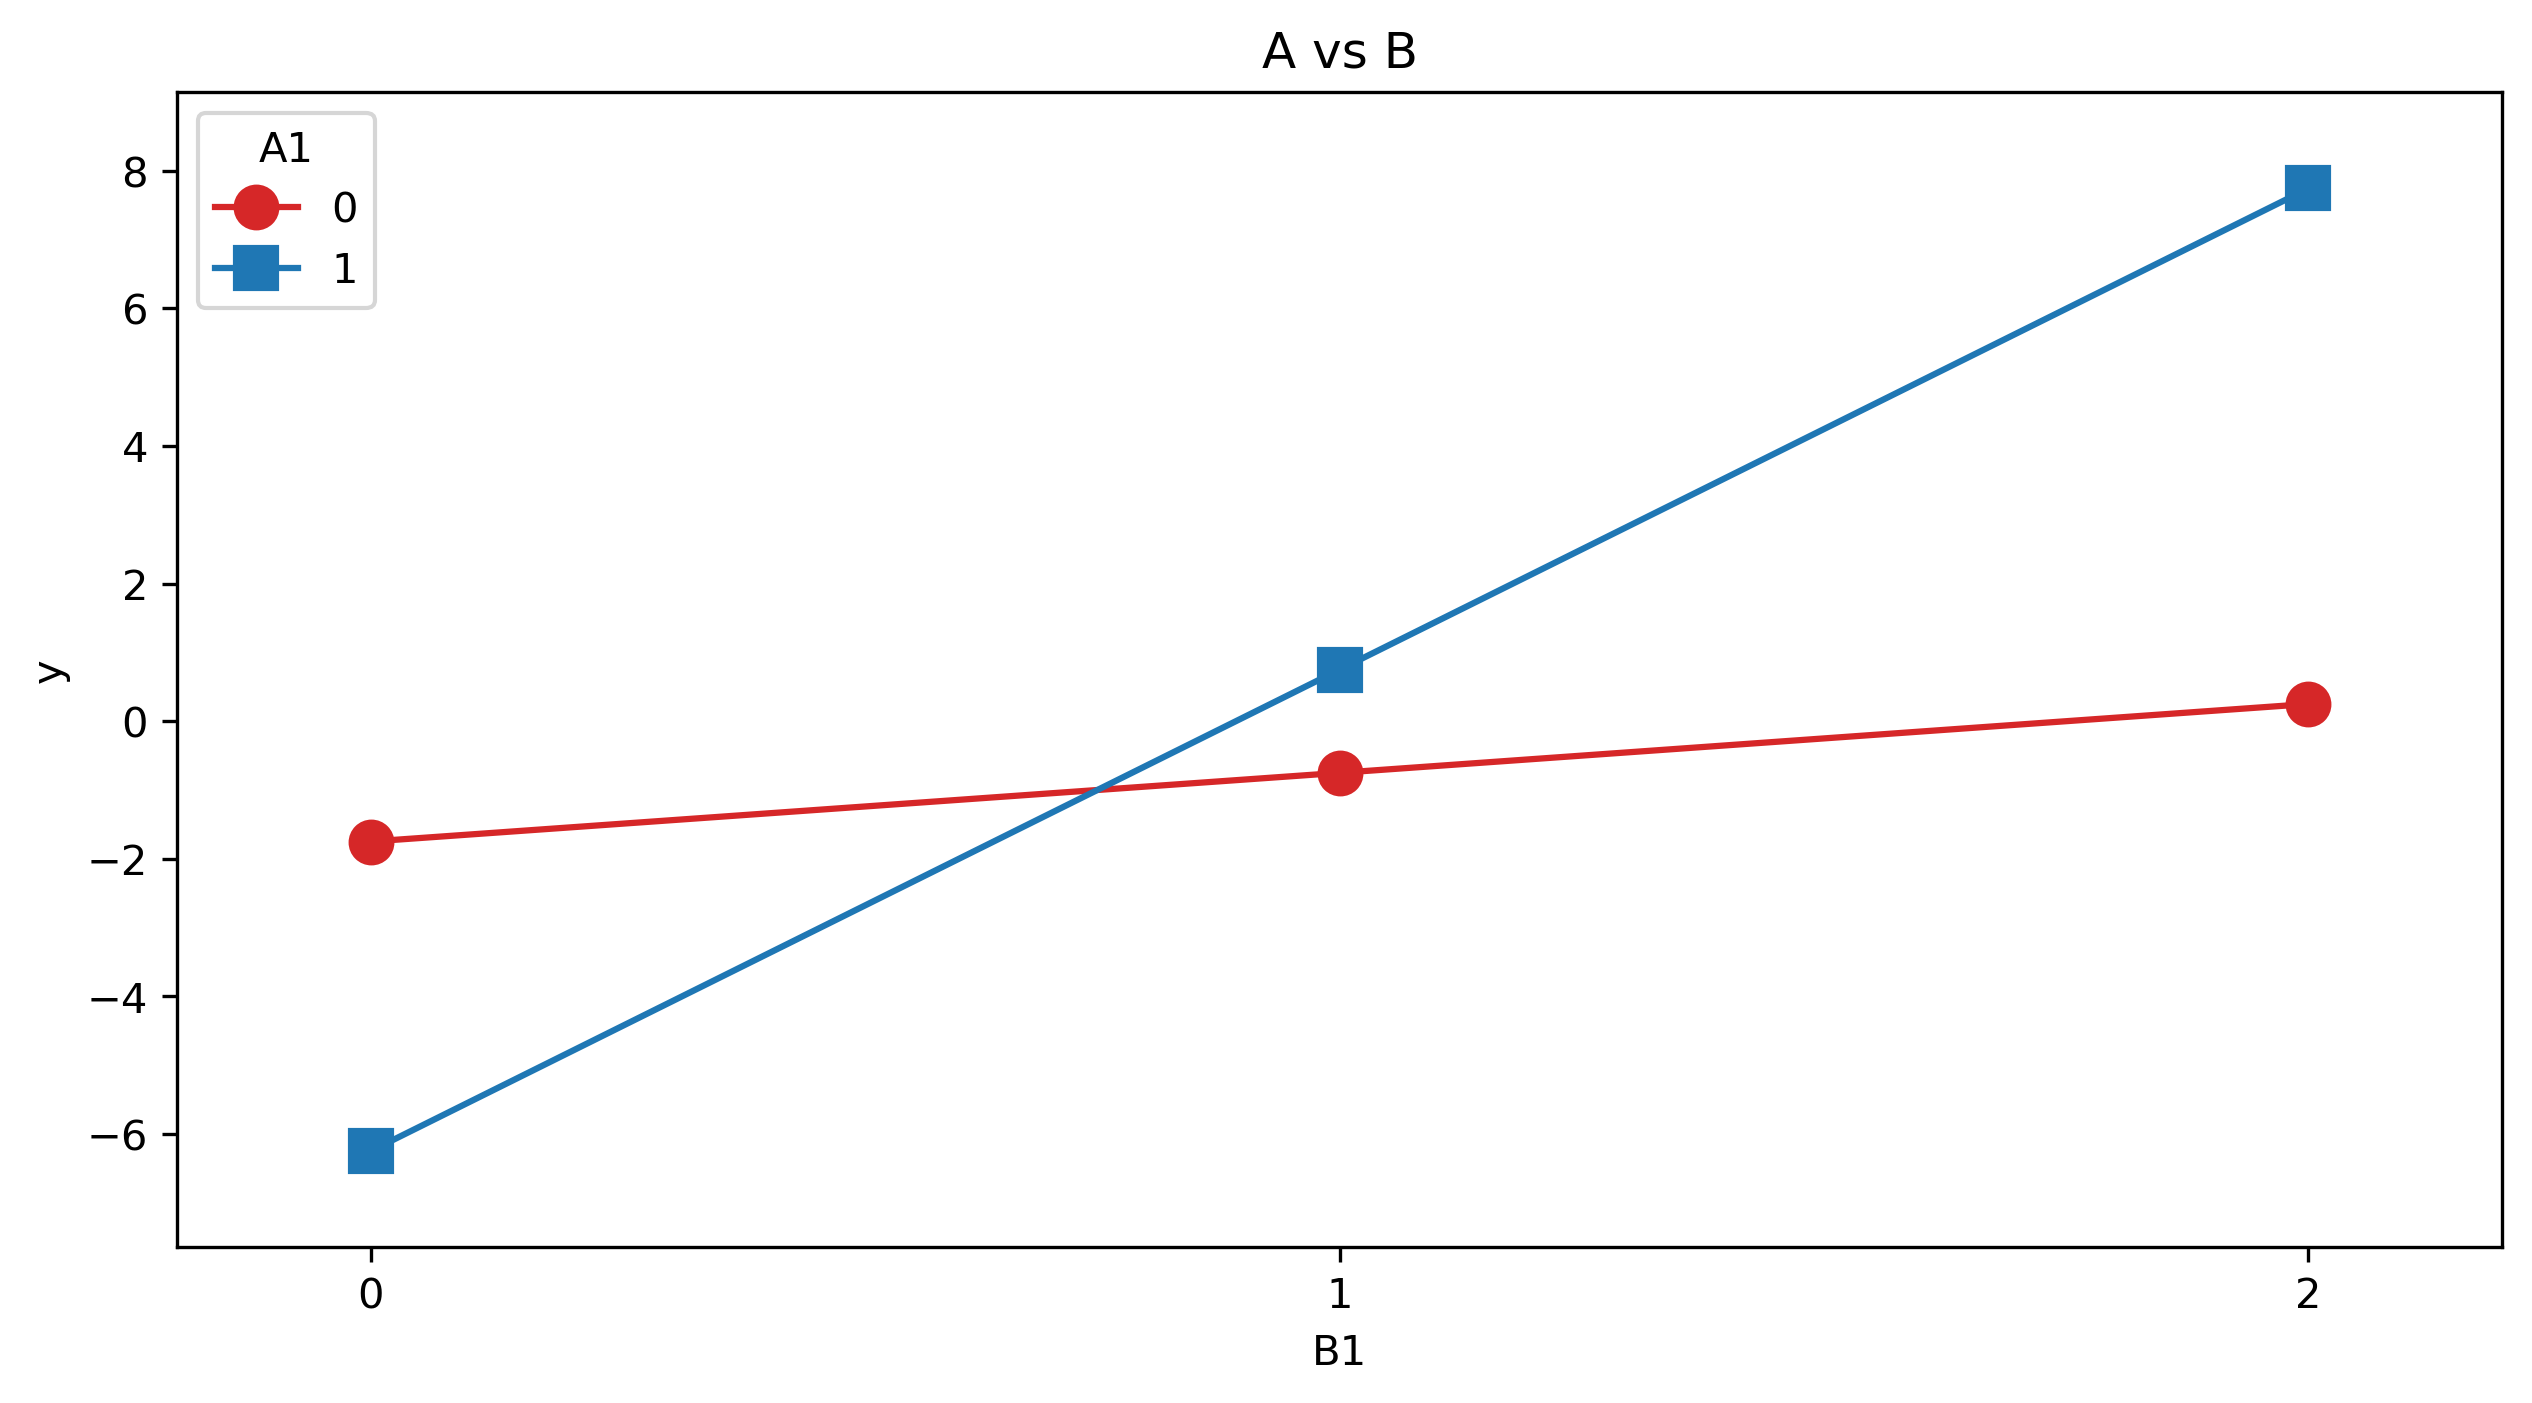

In [243]:
# dropeamos la variable x3

matriz_diseno_3 = matriz_diseno.copy()
matriz_diseno_3 = matriz_diseno_3.drop(columns=['Bloque', 'Rep']) # hay 12 replicas

# interaction plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
interaction_plot(
    x = matriz_diseno_3['B1'],
    trace = matriz_diseno_3['A1'],
    response = matriz_diseno_3['y'],
    colors = ['tab:red', 'tab:blue'],
    markers = ['o', 's'],
    ms = 10,
    ax = ax
)
ax.set_xlabel('B1')
ax.set_ylabel('y')
ax.set_title('A vs B')
ax.set_xticks(matriz_diseno_3['B1'].unique())


> Realice un análisis de varianza sobre el modelo sin bloqueo. 


In [245]:
ols_model_3 = ols('y ~ A1 * B1', data = matriz_diseno_3).fit()
anova_3 = anova_lm(ols_model_3, typ=2)
anova_3.round(10) # para que se vean mejor los p-values

,sum_sq,df,F,PR(>F)
A1,40.467768,1.0,98.861664,0.0
B1,767.429979,2.0,937.405363,0.0
A1:B1,431.645610,2.0,527.249288,0.0
Residual,27.016262,66.0,NaN,NaN


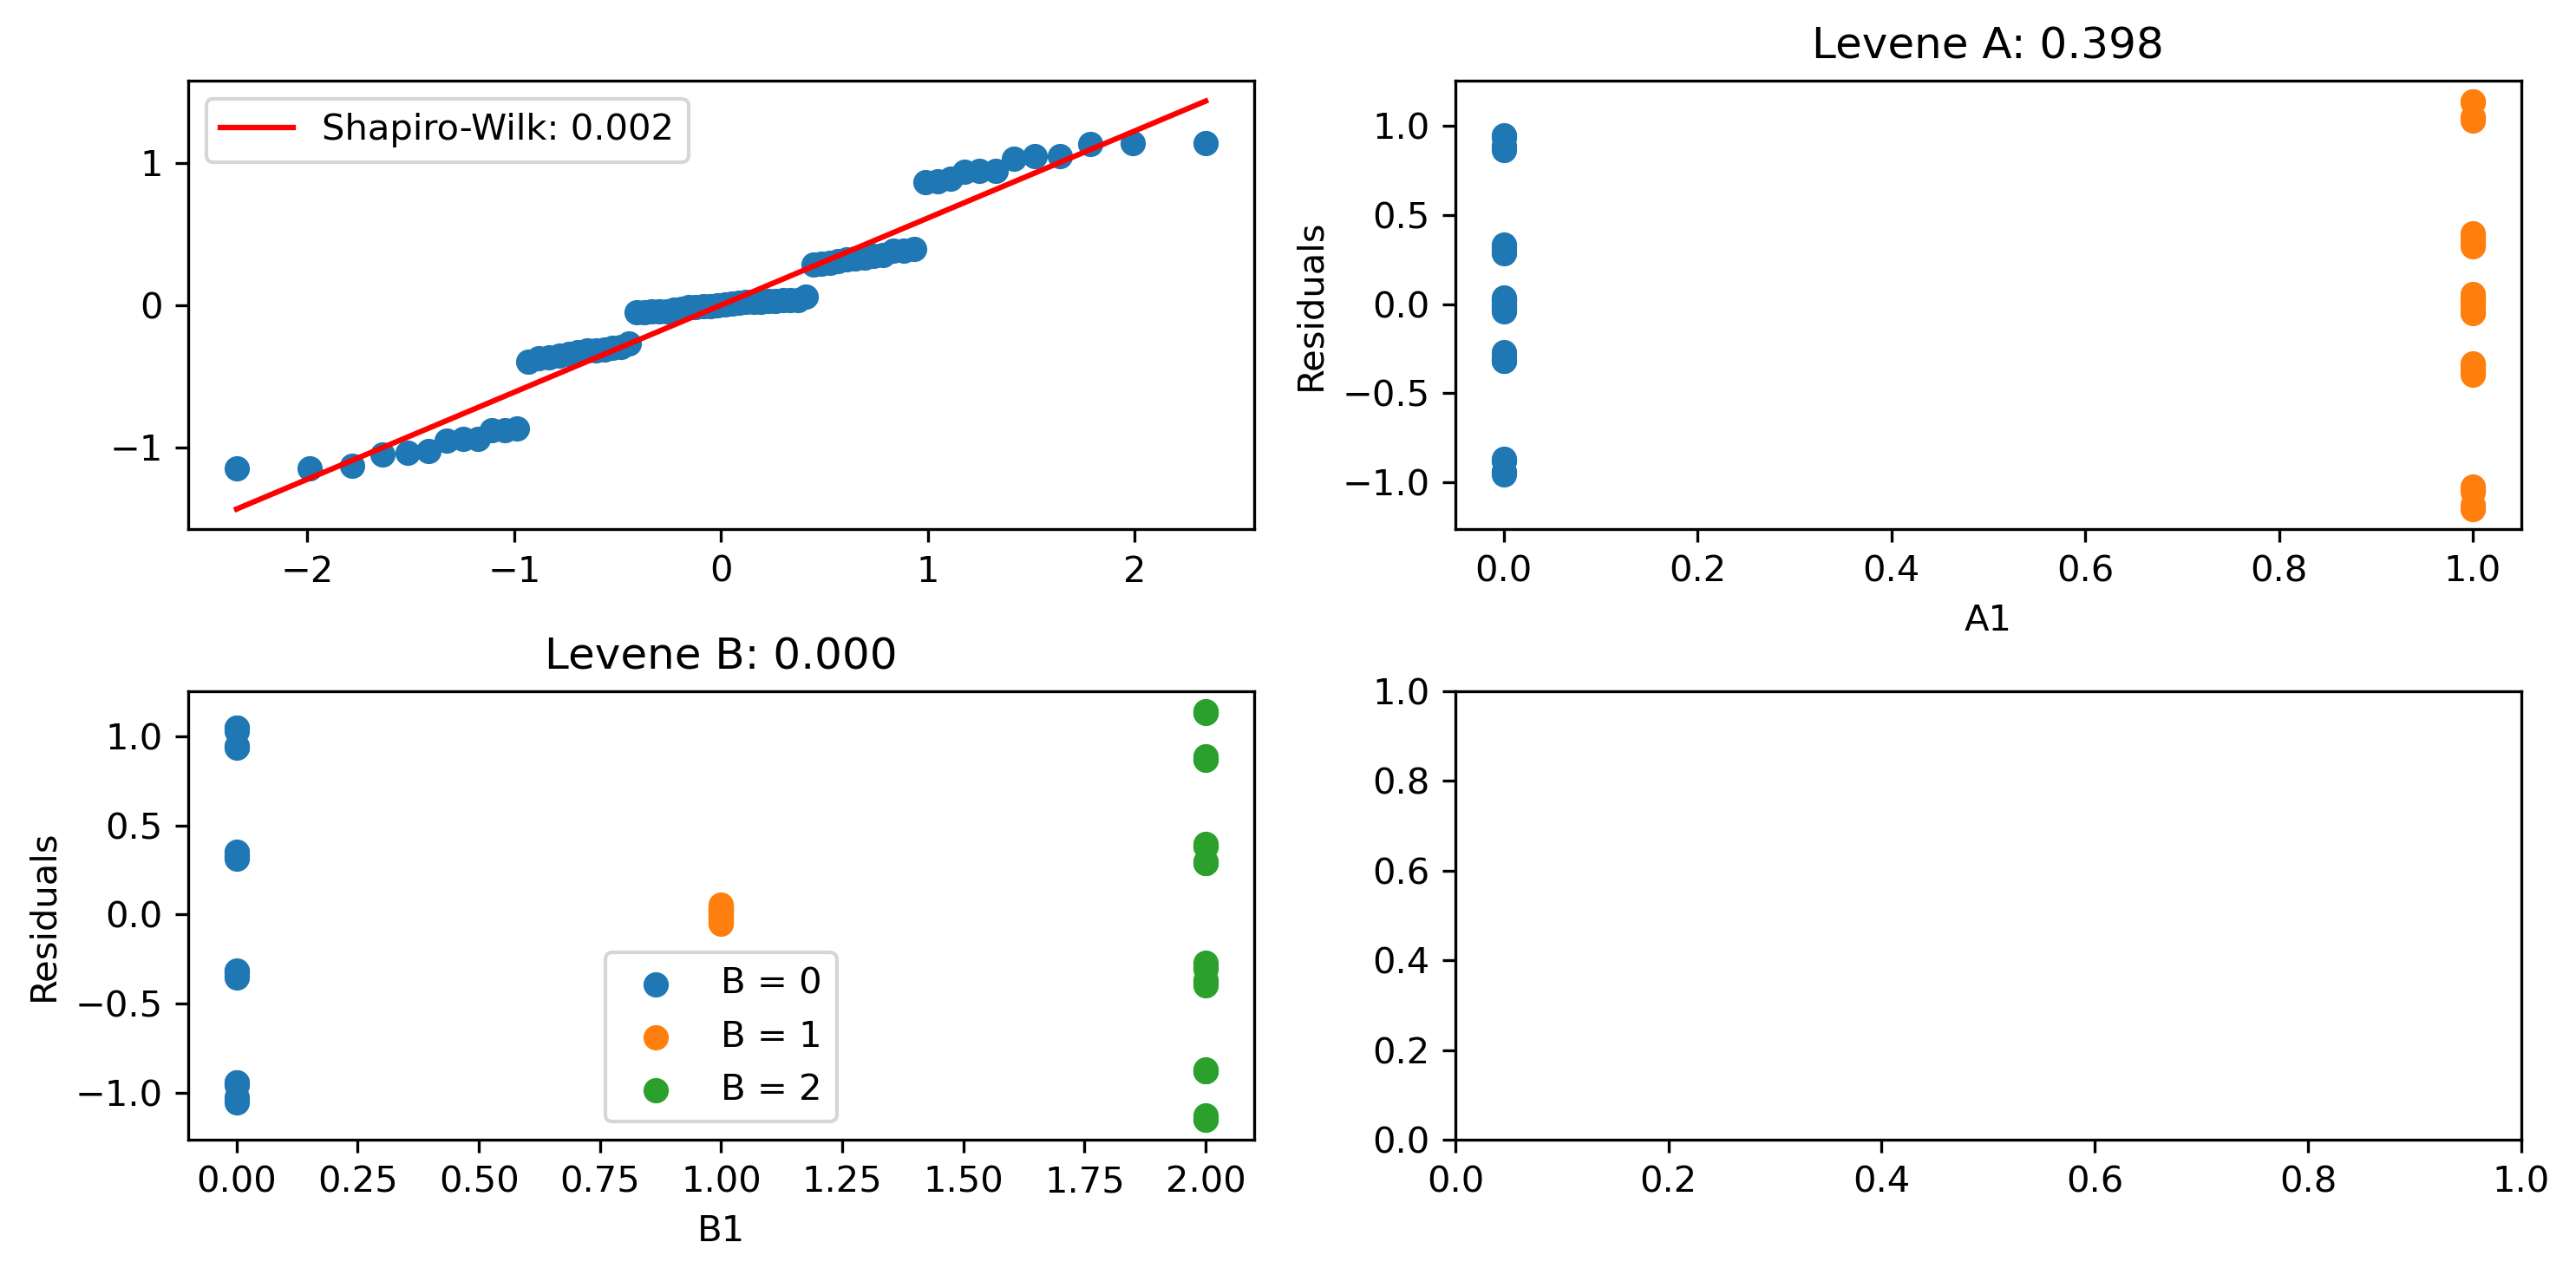

In [252]:
resid = ols_model_3.resid
fig, ax = plt.subplots(2, 2, figsize=(10, 5), dpi = 300)
(osm, osr) , (slope, intercept, r) = stats.probplot(resid, dist = "norm")
shapiro_wilk = stats.shapiro(resid)[1]
ax[0,0].scatter(osm, osr)
ax[0,0].plot(osm, slope * osm + intercept, color = 'red', label = f'Shapiro-Wilk: {shapiro_wilk:.3f}')
ax[0,0].legend()
for i in matriz_diseno_3['A1'].unique():
    resid_a = resid[matriz_diseno_3['A1'] == i]
    ax[0,1].scatter(i * np.ones(len(resid_a)), resid_a, label = f'A = {i}')
levene_A = stats.levene(resid[matriz_diseno_3['A1'] == 0], resid[matriz_diseno_3['A1'] == 1])[1]
ax[0,1].set_xlabel('A1')
ax[0,1].set_ylabel('Residuals')
ax[0,1].set_title('Residuals vs A')
ax[0,1].set_title(f'Levene A: {levene_A:.3f}')
for i in matriz_diseno_3['B1'].unique():
    resid_b = resid[matriz_diseno_3['B1'] == i]
    ax[1,0].scatter(i * np.ones(len(resid_b)), resid_b, label = f'B = {i}')
levene_B = stats.levene(resid[matriz_diseno_3['B1'] == 0], resid[matriz_diseno_3['B1'] == 1])[1]
ax[1,0].set_xlabel('B1')
ax[1,0].legend()
ax[1,0].set_ylabel('Residuals')
ax[1,0].set_title('Residuals vs B')
ax[1,0].set_title(f'Levene B: {levene_B:.3f}')
fig.tight_layout()


## Test Clásicos

> Agrupe los datos por la variable $x_1$. ¿Cuál grupo presenta un mayor promedio en $y$? Genere una comparación estadística (por ejemplo, prueba t o ANOVA de un factor) y reporte su significancia.


/var/folders/zv/p838yyl57rb2tlk802d5y2hh0000gn/T/ipykernel_50770/2661832554.py:11: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



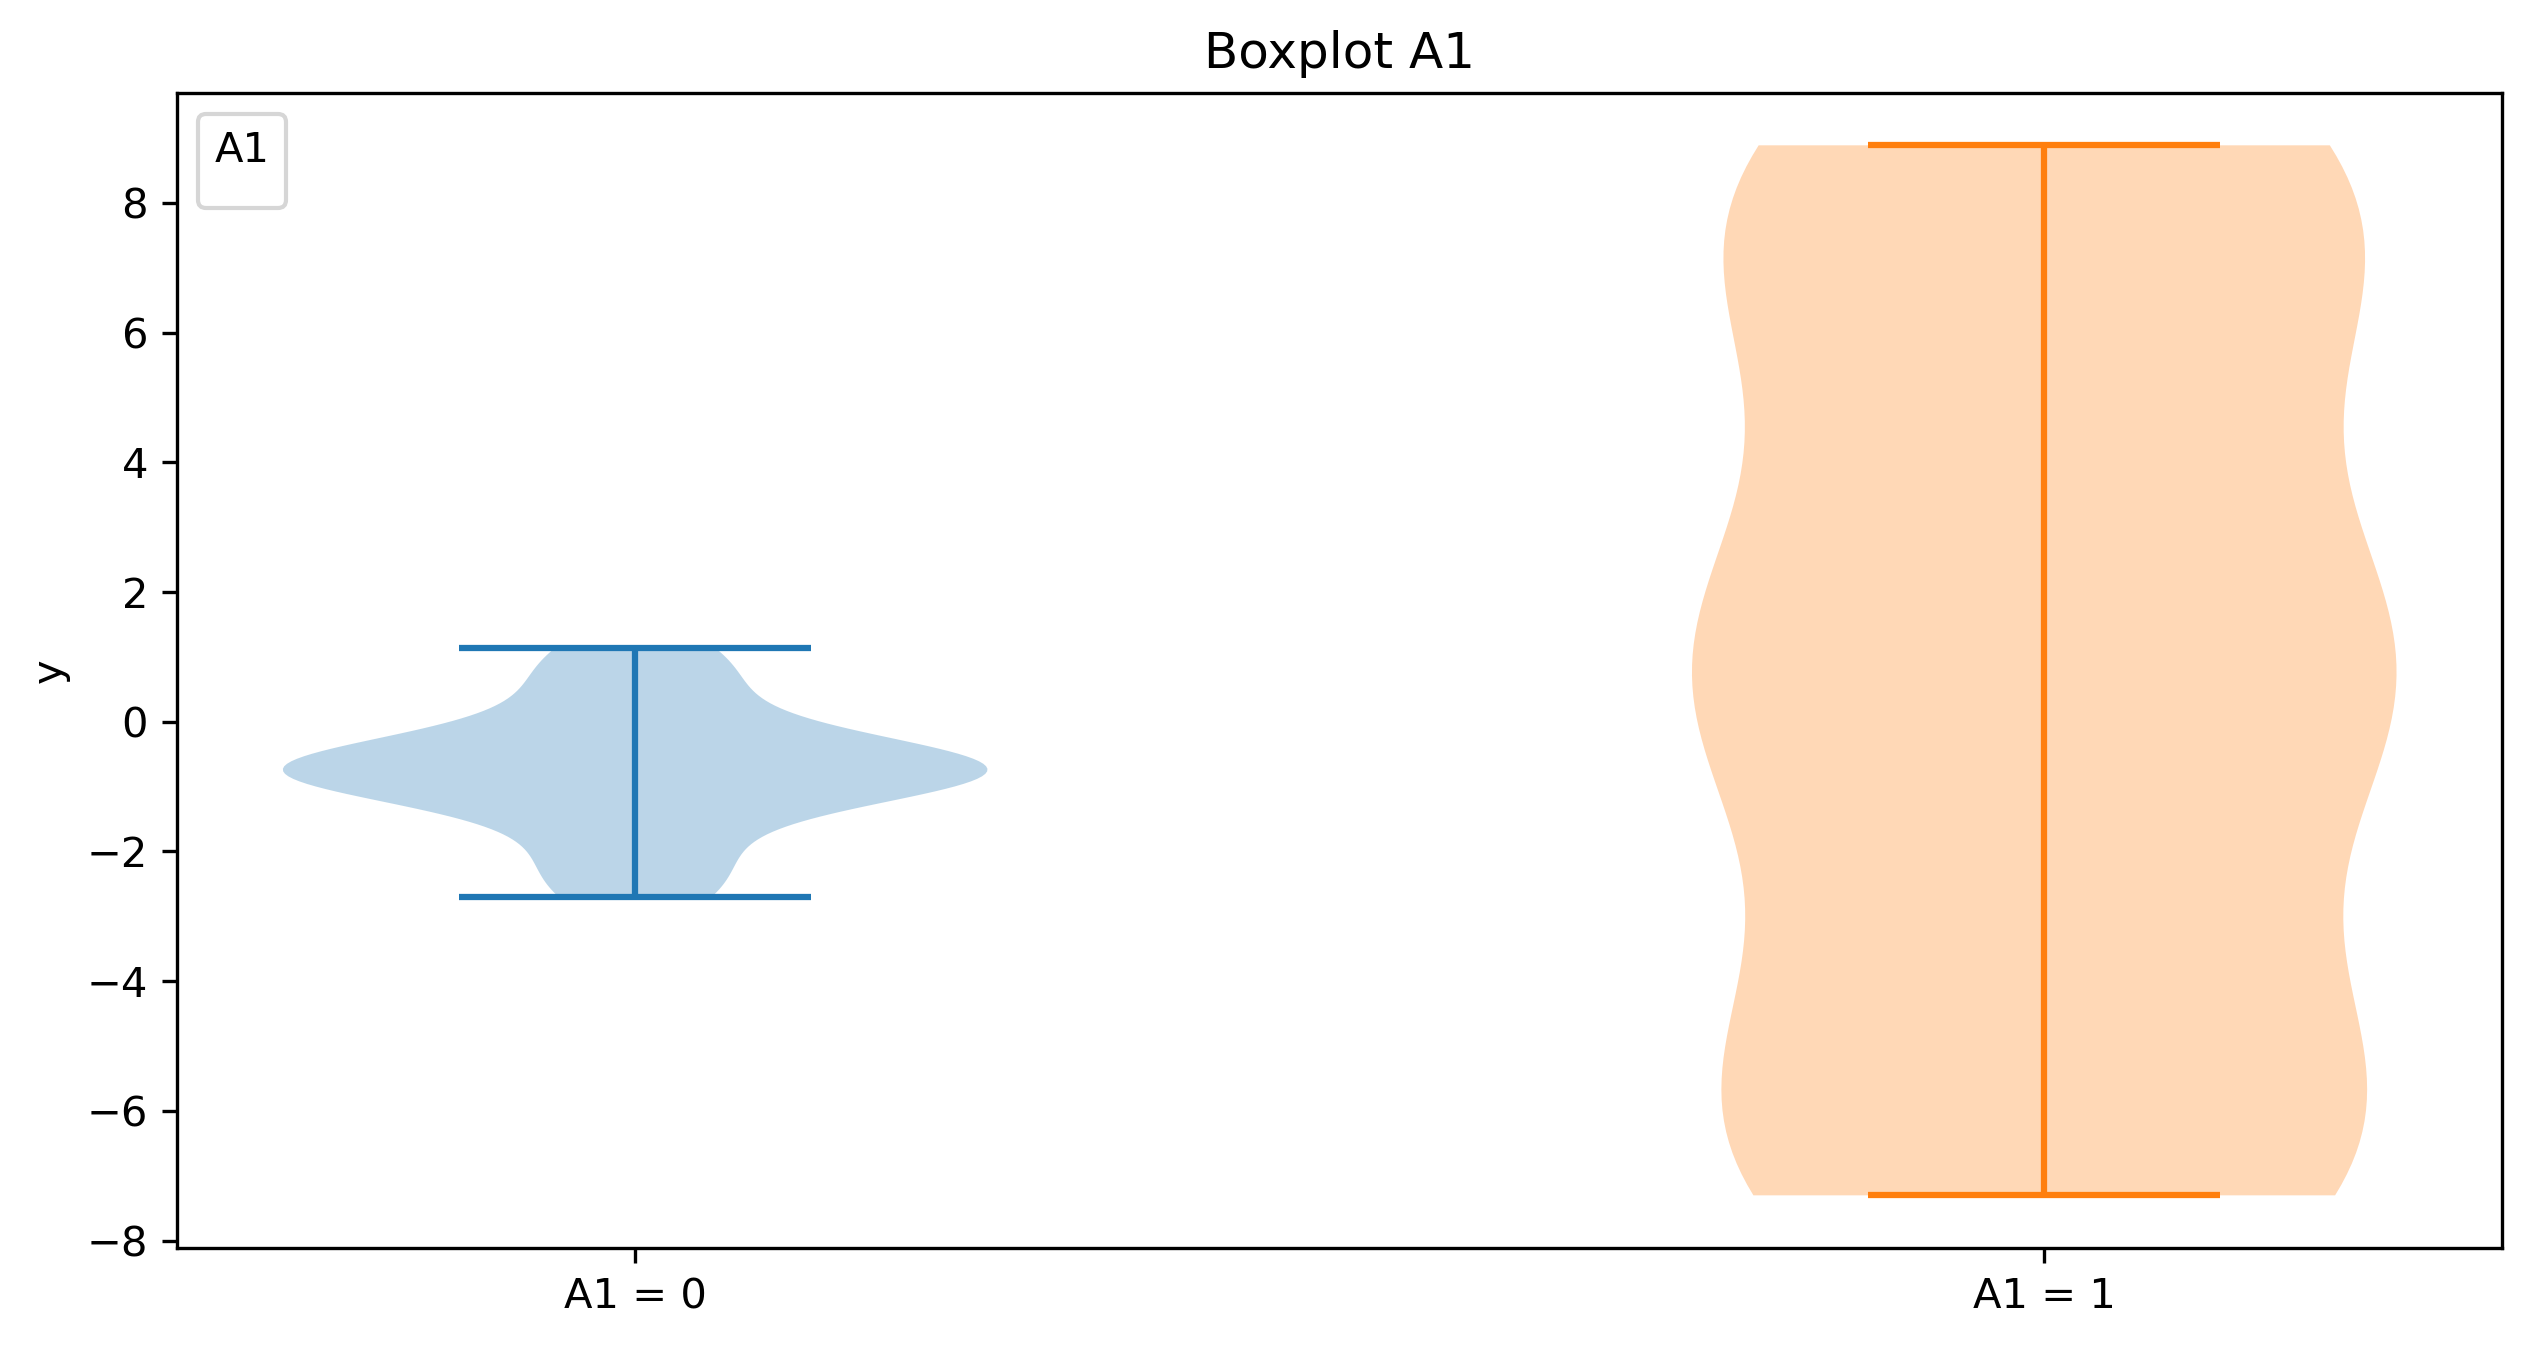

In [255]:
x1_0 = matriz_diseno_3[matriz_diseno_3['A1'] == 0]
x1_1 = matriz_diseno_3[matriz_diseno_3['A1'] == 1]

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
ax.violinplot(x1_0['y'], positions = [0])
ax.violinplot(x1_1['y'], positions = [1])
ax.set_xticks([0, 1])
ax.set_xticklabels(['A1 = 0', 'A1 = 1'])
ax.set_ylabel('y')
ax.set_title('Boxplot A1')
ax.legend(title='A1', loc='upper left')


Podemos ver que las distribuciones no son tan normales, ni homocedasticas. Por lo cuál es importante realizar un test no-paramétrico.

In [261]:
### Kurskal for diference in medians
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu

kruskal_A = kruskal(x1_0['y'], x1_1['y'])
print(f'Kruskal A1: {kruskal_A}')
mannwhitney_A = mannwhitneyu(x1_0['y'], x1_1['y'], alternative='greater')
print(f'Mann Whitney A1 (A0 = 0 > A1 = 1 ): {mannwhitney_A}')
mannwhitney_A = mannwhitneyu(x1_0['y'], x1_1['y'], alternative='less')
print(f'Mann Whitney A1 (A0 = 0 < A1 = 1 ): {mannwhitney_A}')

Kruskal A1: KruskalResult(statistic=np.float64(4.109589041095887), pvalue=np.float64(0.04264072264009575))
Mann Whitney A1 (A0 = 0 > A1 = 1 ): MannwhitneyuResult(statistic=np.float64(468.0), pvalue=np.float64(0.9789658205124703))
Mann Whitney A1 (A0 = 0 < A1 = 1 ): MannwhitneyuResult(statistic=np.float64(468.0), pvalue=np.float64(0.021609828777667928))


Probemos ahora al comparar los diferentes grupos de B.

Text(0.5, 1.0, 'Boxplot B1')

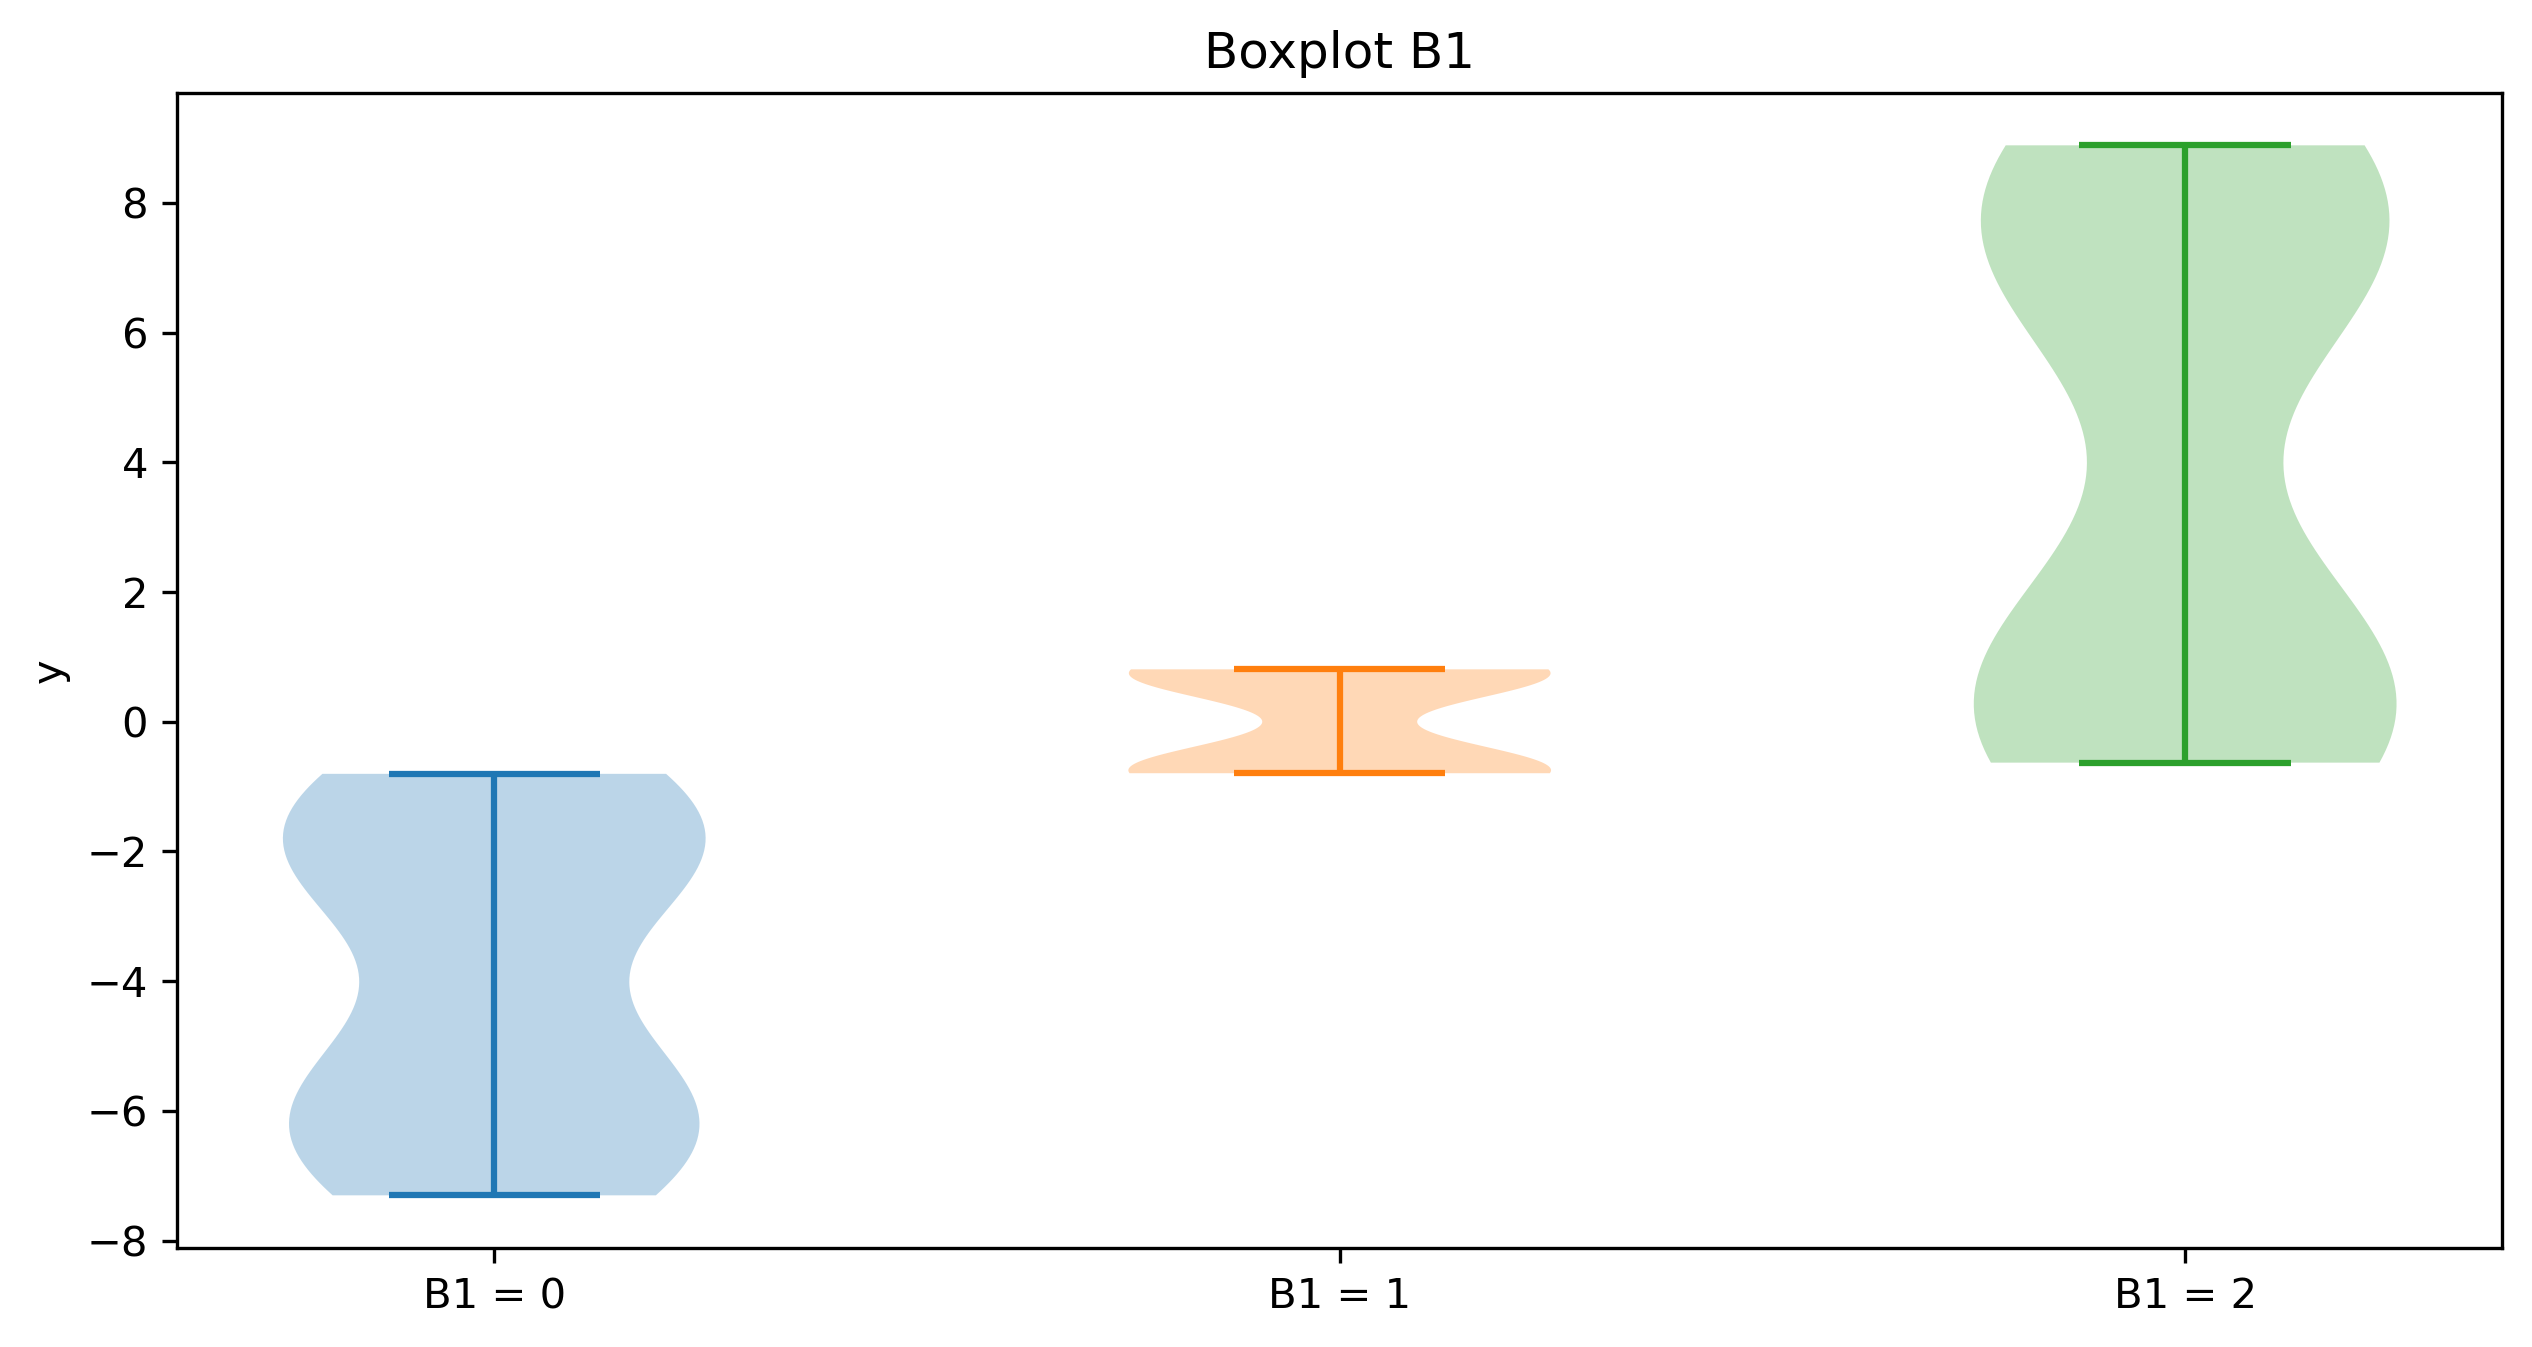

In [264]:
x2_0 = matriz_diseno_3[matriz_diseno_3['B1'] == 0]
x2_1 = matriz_diseno_3[matriz_diseno_3['B1'] == 1]
x2_2 = matriz_diseno_3[matriz_diseno_3['B1'] == 2]

fig, ax = plt.subplots(1, 1, figsize=(10, 5), dpi = 300)
ax.violinplot(x2_0['y'], positions = [0])
ax.violinplot(x2_1['y'], positions = [1])
ax.violinplot(x2_2['y'], positions = [2])
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['B1 = 0', 'B1 = 1', 'B1 = 2'])
ax.set_ylabel('y')
ax.set_title('Boxplot B1')



Podemos ver a simple vista que los grupos no son normales. Así que denuevo recurrimos a pruebas no paramétricas.

In [265]:
# vemos 

kurskal_B = kruskal(x2_0['y'], x2_1['y'], x2_2['y'])
print(f'Kruskal B1: {kurskal_B}')

Kruskal B1: KruskalResult(statistic=np.float64(53.50684931506845), pvalue=np.float64(2.4051119669882993e-12))


Ahora podemos realizar un test no-paramétrico de forma pareada -no test pareados- para poder comparar las diferentes medias y así evaluar los efectos de los tratamientos.

In [273]:
# prueba mannwhitney pairwise
import pingouin as pg

pg.pairwise_tests(dv = 'y', between = 'B1', data = matriz_diseno_3, parametric=False, alternative = 'less')


,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,hedges
0,B1,0,1,False,False,0.0,less,1.531832e-09,-2.191458
1,B1,0,2,False,False,0.0,less,1.531832e-09,-2.420989
2,B1,1,2,False,False,108.0,less,1.072794e-04,-1.397159


En este caso, se nos da confianza que lo que se pudo ver en el gráfico es real. Y en realidad se tiene que para los diferentes B, el efecto de 0 es menor a 1 y este último a 2. Es decir, $B_0 < B_1 < B_2$.

## Estimación de Efecto

> Estime los parámetros del modelo de efectos principales e interacciones (solo entre $x_1$ y $x_2$). ¿Cuál variable tiene mayor efecto sobre la respuesta?

Realizamos un procedimiento similar al que se realizó previamente para estimar los efectos de las variables. Con esto obtenemos:

In [275]:
mu = matriz_diseno_3['y'].mean()
A_means = matriz_diseno_3.groupby('A1', observed=True)['y'].mean()
B_means = matriz_diseno_3.groupby('B1', observed=True)['y'].mean()
AB_means = matriz_diseno_3.groupby(['A1', 'B1'], observed=True)['y'].mean()
A_effect = A_means - mu
B_effect = B_means - mu
interactions_AB = (
    AB_means
    - A_means
    - B_means
    + mu
)

print('Grand Mean')
display(mu)
print('Factor A')
display(A_effect)
print('Factor B')
display(B_effect)
print('Interaction AB')
display(interactions_AB)

Grand Mean


np.float64(-0.0007921028461682016)

Factor A


A1
0   -0.749701
1    0.749701
Name: y, dtype: float64

Factor B


B1
0   -3.998521
1    0.000012
2    3.998509
Name: y, dtype: float64

Interaction AB


A1  B1
0   0     2.999089
    1    -0.000640
    2    -2.998449
1   0    -2.999089
    1     0.000640
    2     2.998449
Name: y, dtype: float64